In [1]:
# Importando as bibliotecas necessárias
import pandas as pd
import numpy as np
import random
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import GRU, Dense, Dropout
from keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from google.colab import drive
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
import os
from tqdm import tqdm
import pickle

In [2]:
# Carregar o drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
#200 trials n_layers': 1, 'n_units_GRU1': 115, 'dropout_rate_GRU1': 0.0009899544402645344, 'activation_GRU1': 'relu', 'n_units_dense': 52, 'activation_dense': 'relu', 'optimizer': 'adam', 'lookback': 7, 'batch_size': 64, 'learning_rate': 0.007770164265048791

##50 trials
n_layers': 1, 'n_units_GRU1': 205, 'dropout_rate_GRU1': 0.16216244641644745, 'activation_GRU1': 'tanh', 'n_units_dense': 55, 'activation_dense': 'tanh', 'optimizer': 'sgd', 'lookback': 3, 'batch_size': 32, 'learning_rate': 0.004489228753135746}


In [3]:
'''# Definição de hiperparametros *Melhores apos 50 trials do optuna High

n_layers = 1
n_units_GRU1 = 208
dropout_rate_GRU1 = 0.09876576801277778
activation_GRU1 = 'relu'
n_units_dense = 34
activation_dense = 'relu'
optimizer = 'adam'
lookback = 3
batch_size = 64
learning_rate = 0.009911782526393935'''

In [3]:
'''#Hiperparametros Low
n_layers = 1
n_units_GRU1 = 149
dropout_rate_GRU1 = 0.20132677436380386
activation_GRU1 = 'tanh'
n_units_dense = 45
activation_dense = 'tanh'
optimizer = 'adam'
lookback = 7
batch_size = 64
learning_rate = 0.0024882308467470437'''


In [3]:
'''#Hiperparametros Volume
n_layers = 1
n_units_GRU1 = 102
dropout_rate_GRU1 = 0.13999593011269934
activation_GRU1 = 'tanh'
n_units_dense = 17
activation_dense = 'relu'
optimizer = 'rmsprop'
lookback = 11
batch_size = 128
learning_rate = 0.0015029914908654448'''

In [3]:
#Hiperparametros USD
n_layers = 1
n_units_GRU1 = 206
dropout_rate_GRU1 = 0.4885298953575753
activation_GRU1 = 'relu'
n_units_dense = 39
activation_dense = 'tanh'
optimizer = 'sgd'
lookback = 11
batch_size = 128
learning_rate = 0.002829719725404078

In [4]:
# Carregar o arquivo CSV sem índice e com a coluna 'Date' no formato datetime
df = pd.read_csv(
    "/content/drive/MyDrive/Mestrado/df_indice_brasil_endogenous_exogenous_red1.csv",
    sep=',',
    parse_dates=['Date'],  # Converte a coluna 'Date' para datetime
    index_col=None         # Não define uma coluna de índice
)

# Visualizar as primeiras linhas para confirmar o carregamento
df.head()

,Unnamed: 0,Date,Close,High,Low,Volume,USD
0,0,2013-01-02,62550.10,62887.0,60990.0,3739800.0,2.0456
1,1,2013-01-03,63312.46,63473.0,62341.0,3355800.0,2.0456
2,2,2013-01-04,62523.06,63314.0,62415.0,6233800.0,2.0487
3,3,2013-01-07,61932.54,62699.0,61639.0,3985800.0,2.0324
4,4,2013-01-08,61127.84,62265.0,61081.0,3840600.0,2.0264


In [5]:
#carregar base de dados
# Selecionar apenas as colunas desejadas
df = df[['Date', 'Close', 'High', 'Low', 'Volume', 'USD']]

# Verificar as informações do DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2724 entries, 0 to 2723
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2724 non-null   datetime64[ns]
 1   Close   2724 non-null   float64       
 2   High    2724 non-null   float64       
 3   Low     2724 non-null   float64       
 4   Volume  2724 non-null   float64       
 5   USD     2724 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 127.8 KB


In [6]:
#separação dos dados em treino, validação e teste
train_size = int(len(df['Close']) * 0.75)
val_size = int(len(df['Close']) * 0.85)

df_train = df.iloc[:train_size].copy()
df_test = df.iloc[val_size:].copy()

In [7]:
def save_model(model, optimizer, metrics, seed, filename='bestresults'):
    # Salvar o modelo e suas métricas
    model.save(filename + '.keras')
    with open(filename + '.txt', 'w') as f:
        for key, value in metrics.items():
            f.write(f'{key}: {value}\n')
        f.write(f'Seed: {seed}\n')

    # Salvar o otimizador
    with open(filename + '_optimizer.pkl', 'wb') as f:
        pickle.dump(optimizer.get_config(), f)

In [8]:
# Criação de diretório e salvar modelos e history
patience = 10
runs=100
results_dir = f'/content/drive/MyDrive/GRU/GRU_p{patience}_bestresults'

best_model = None
best_history = None
best_mape = float('inf')
all_metrics = []
all_history = []

In [9]:
# Normalização das colunas 'Close' e 'Volume' no conjunto de treino
train_mean = df_train[['Close', 'USD']].mean().values
train_std = df_train[['Close', 'USD']].std().values

train_not_norm = df_train[['Close', 'USD']].to_numpy()
test_not_norm = df_test[['Close']].to_numpy()

# Normalização do conjunto de treino e teste
train_norm = (train_not_norm - train_mean) / train_std
test_norm = (test_not_norm - train_mean) / train_std  # usa stats de treino

# Preparação dos dados de treino e validação com exógena 'Volume'
train_dataset = tf.keras.utils.timeseries_dataset_from_array(
    data=train_norm[:-1],
    targets=train_norm[lookback:, 0],  # Target é 'Close'
    sequence_length=lookback,
    shuffle=False,
    batch_size=batch_size
)

val_dataset = tf.keras.utils.timeseries_dataset_from_array(
    data=test_norm[:-1],
    targets=test_norm[lookback:, 0],  # Target é 'Close'
    sequence_length=lookback,
    shuffle=False,
    batch_size=batch_size
)

# Configuração para múltiplos runs
all_metrics = []
all_history = []

# Criação do diretório de resultados
os.makedirs(results_dir, exist_ok=True)

# Loop para os múltiplos runs
for run_num in tqdm(range(runs)):
    # Definir seed para reprodutibilidade
    seed = run_num
    np.random.seed(seed)
    tf.random.set_seed(seed)

    print(f"\nStarting Run {run_num} with seed {seed}")

    # Definir e compilar o modelo LSTM
    model = Sequential()
    model.add(GRU(n_units_GRU1, activation=activation_GRU1, input_shape=(lookback, 2), return_sequences=False))
    model.add(Dropout(dropout_rate_GRU1))
    model.add(Dense(n_units_dense, activation=activation_dense))
    model.add(Dense(1))

    # Compilar o modelo
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='mae')

    # Callback de early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    # Treinar o modelo
    history = model.fit(
        train_dataset,
        epochs=200,
        validation_data=val_dataset,
        callbacks=[early_stopping],
        verbose=1
    )

    # Fazer previsões
    val_predict = model.predict(val_dataset)
    # Desnormalizar as previsões de 'Close'
    predict = (val_predict * train_std[0]) + train_mean[0]

    # Ajustar y_real e y_predict para o cálculo de métricas
    y_real = test_not_norm[lookback:, 0]  # 'Close' desnormalizado
    y_predict = predict.squeeze()

    # Ajustar o tamanho de y_predict
    if len(y_real) != len(y_predict):
        y_predict = y_predict[:len(y_real)]

    # Calcular métricas
    mae = mean_absolute_error(y_real, y_predict)
    mse = mean_squared_error(y_real, y_predict)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_real - y_predict) / y_real)) * 100
    r2 = r2_score(y_real, y_predict)

    # Exibir e armazenar métricas
    print(f"Run {run_num}, Seed {seed}")
    print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}, MAPE: {mape}, R2: {r2}")

    # Salvar histórico e métricas
    run_metrics = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'MAPE': mape, 'R2': r2, 'Run': run_num}
    all_metrics.append(run_metrics)
    all_history.append(history.history)

# Salvar métricas e histórico
np.save(os.path.join(results_dir, "all_metrics.npy"), all_metrics)
np.save(os.path.join(results_dir, "all_history.npy"), all_history)

  0%|          | 0/100 [00:00<?, ?it/s]


Starting Run 0 with seed 0
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - loss: 0.5353 - val_loss: 1.7300
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.3739 - val_loss: 2.3768
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.4543 - val_loss: 3.9738
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.5766 - val_loss: 4.3824
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - loss: 0.1528 - val_loss: 1.8145
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.2980 - val_loss: 2.6178
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.2548 - val_loss: 3.1176
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.4051 - val_loss: 3.2548
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.1865 - val_loss: 2.3215
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.3777 - val_loss: 2.8632
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.1748 - val_loss: 3.3188
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step


  1%|          | 1/100 [00:19<31:27, 19.07s/it]

Run 0, Seed 0
MAE: 38463.51065169598, MSE: 1539969561.0122666, RMSE: 39242.44591016552, MAPE: 34.944710709714656, R2: -24.975540731743937

Starting Run 1 with seed 1
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 226ms/step - loss: 0.4537 - val_loss: 0.5143
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.3198 - val_loss: 1.2861
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.6432 - val_loss: 3.2411
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.6138 - val_loss: 1.1609
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.3557 - val_loss: 0.2816
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3189 - val_loss: 5.3829
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.2891 - val_loss: 6.4516
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.2007 - val_loss: 1.6117
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.3735 - val_loss: 4.4301
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - loss: 0.1703 - val_loss: 2.8402
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - loss: 0.3109 - val_loss: 2.7867
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - loss

  2%|▏         | 2/100 [00:46<39:16, 24.04s/it]

Run 1, Seed 1
MAE: 6260.205971262563, MSE: 64884595.69086148, RMSE: 8055.09749729086, MAPE: 5.567820591631618, R2: -0.09444530651816185

Starting Run 2 with seed 2
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - loss: 0.4782 - val_loss: 2.3445
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.3885 - val_loss: 0.8167
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.3032 - val_loss: 4.6542
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - loss: 0.6341 - val_loss: 0.4894
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.2969 - val_loss: 1.3898
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.3897 - val_loss: 1.3903
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.2388 - val_loss: 1.5114
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.1655 - val_loss: 0.2992
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.1878 - val_loss: 2.3291
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.2382 - val_loss: 0.4664
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.1437 - val_loss: 2.0009
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


  3%|▎         | 3/100 [01:17<43:46, 27.08s/it]

Run 2, Seed 2
MAE: 6651.741649654523, MSE: 69159796.09116256, RMSE: 8316.23689484388, MAPE: 6.116211081412586, R2: -0.16655753843876697

Starting Run 3 with seed 3
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - loss: 0.5705 - val_loss: 1.8779
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - loss: 0.4325 - val_loss: 2.1495
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - loss: 0.2259 - val_loss: 4.4940
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.3234 - val_loss: 0.5478
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.1806 - val_loss: 0.9304
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.4165 - val_loss: 2.5386
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.3264 - val_loss: 3.2492
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.1335 - val_loss: 3.8481
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.1997 - val_loss: 3.1990
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.1450 - val_loss: 4.2249
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.1388 - val_loss: 4.0117
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - loss: 

  4%|▍         | 4/100 [01:42<42:00, 26.26s/it]

Run 3, Seed 3
MAE: 12178.934697707287, MSE: 247233665.3175303, RMSE: 15723.665772253311, MAPE: 10.726362212126423, R2: -3.1702305722799293

Starting Run 4 with seed 4
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - loss: 0.4629 - val_loss: 0.5215
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.3938 - val_loss: 1.9976
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.7500 - val_loss: 3.8347
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.6666 - val_loss: 2.1773
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.4483 - val_loss: 0.3618
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - loss: 0.4080 - val_loss: 2.0173
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.1962 - val_loss: 3.5534
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.1721 - val_loss: 1.2674
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.3125 - val_loss: 4.7311
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.2481 - val_loss: 3.4555
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.1775 - val_loss: 4.1065
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.

  5%|▌         | 5/100 [02:07<40:48, 25.77s/it]

Run 4, Seed 4
MAE: 8043.377264447236, MSE: 102501270.59203558, RMSE: 10124.291115531772, MAPE: 7.029353855156119, R2: -0.7289471147525615

Starting Run 5 with seed 5
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 0.4274 - val_loss: 0.4653
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.3852 - val_loss: 2.1766
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.7272 - val_loss: 2.1151
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.6343 - val_loss: 1.7672
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.2307 - val_loss: 0.3304
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.3507 - val_loss: 4.4517
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.2501 - val_loss: 1.0958
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - loss: 0.2121 - val_loss: 1.8775
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - loss: 0.3284 - val_loss: 3.3823
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 0.2146 - val_loss: 2.1397
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.1558 - val_loss: 0.8052
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0

  6%|▌         | 6/100 [02:32<40:02, 25.56s/it]

Run 5, Seed 5
MAE: 7345.494228172109, MSE: 84271168.53793804, RMSE: 9179.93292665791, MAPE: 6.381691510475508, R2: -0.42144963529667545

Starting Run 6 with seed 6
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - loss: 0.5649 - val_loss: 1.5241
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - loss: 0.4206 - val_loss: 2.5863
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.4861 - val_loss: 4.9692
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.5934 - val_loss: 4.8335
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.1629 - val_loss: 0.3815
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.1711 - val_loss: 5.4271
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3125 - val_loss: 7.1212
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3103 - val_loss: 1.8232
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - loss: 0.2024 - val_loss: 2.5380
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - loss: 0.2043 - val_loss: 4.1476
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - loss: 0.1454 - val_loss: 4.3463
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss:

  7%|▋         | 7/100 [03:00<41:02, 26.48s/it]

Run 6, Seed 6
MAE: 8481.03676821608, MSE: 107980877.84474635, RMSE: 10391.384789562282, MAPE: 7.293529609871466, R2: -0.8213747607205679

Starting Run 7 with seed 7
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - loss: 0.5201 - val_loss: 1.5416
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - loss: 0.4252 - val_loss: 2.1943
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - loss: 0.5705 - val_loss: 3.6721
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.5616 - val_loss: 3.7723
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.2039 - val_loss: 2.8756
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.2509 - val_loss: 2.6912
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.5046 - val_loss: 2.6409
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.3212 - val_loss: 5.1069
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3142 - val_loss: 4.6475
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.5216 - val_loss: 3.6459
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.2127 - val_loss: 5.0633
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step


  8%|▊         | 8/100 [03:21<37:56, 24.75s/it]

Run 7, Seed 7
MAE: 34273.76886306533, MSE: 1260399407.9595366, RMSE: 35502.10427509243, MAPE: 31.233051408472363, R2: -20.259872265396094

Starting Run 8 with seed 8
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - loss: 0.4013 - val_loss: 0.5842
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.3062 - val_loss: 1.1692
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.5519 - val_loss: 4.0817
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.6415 - val_loss: 3.1908
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - loss: 0.3090 - val_loss: 0.4411
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - loss: 0.3784 - val_loss: 2.0831
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - loss: 0.2977 - val_loss: 2.4270
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 0.1981 - val_loss: 0.6758
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.2972 - val_loss: 4.1406
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.2646 - val_loss: 4.6414
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.1643 - val_loss: 3.6782
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 

  9%|▉         | 9/100 [03:51<39:55, 26.33s/it]

Run 8, Seed 8
MAE: 9807.59458856784, MSE: 134330204.56819, RMSE: 11590.090792059827, MAPE: 9.113811368309399, R2: -1.265823811459557

Starting Run 9 with seed 9
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - loss: 0.4866 - val_loss: 2.0975
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.1913 - val_loss: 3.4449
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.3339 - val_loss: 3.0491
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.5348 - val_loss: 0.5879
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.4847 - val_loss: 2.2461
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.6383 - val_loss: 0.9777
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - loss: 0.3620 - val_loss: 0.7374
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - loss: 0.5858 - val_loss: 4.3157
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.5073 - val_loss: 1.7963
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.2517 - val_loss: 0.5083
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.4442 - val_loss: 3.6782
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 

 10%|█         | 10/100 [04:24<42:45, 28.51s/it]

Run 9, Seed 9
MAE: 11301.724909704773, MSE: 185438414.33612755, RMSE: 13617.577403346293, MAPE: 9.766755088641082, R2: -2.1278949966074823

Starting Run 10 with seed 10
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - loss: 0.4570 - val_loss: 2.0410
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.3149 - val_loss: 3.2370
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.5529 - val_loss: 3.3247
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - loss: 0.7193 - val_loss: 1.0853
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - loss: 0.4142 - val_loss: 0.5549
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.3527 - val_loss: 2.9804
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.1888 - val_loss: 2.2789
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.2020 - val_loss: 2.0405
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.2594 - val_loss: 3.2384
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.3407 - val_loss: 2.6328
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.2627 - val_loss: 2.0476
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0

 11%|█         | 11/100 [04:51<41:22, 27.89s/it]

Run 10, Seed 10
MAE: 12337.904963096735, MSE: 193969485.97395125, RMSE: 13927.292844409902, MAPE: 11.44125250661129, R2: -2.2717934244881293

Starting Run 11 with seed 11
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - loss: 0.4661 - val_loss: 0.4533
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.3802 - val_loss: 1.8051
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.5587 - val_loss: 3.2890
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.6596 - val_loss: 1.6977
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.2466 - val_loss: 0.2776
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.4434 - val_loss: 5.3856
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - loss: 0.2882 - val_loss: 5.0078
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - loss: 0.1587 - val_loss: 3.5577
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.2530 - val_loss: 5.5837
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.2054 - val_loss: 2.5794
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.1279 - val_loss: 3.6798
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0

 12%|█▏        | 12/100 [05:15<39:06, 26.67s/it]

Run 11, Seed 11
MAE: 6172.791319095477, MSE: 60368698.30952518, RMSE: 7769.729616243102, MAPE: 5.58161361607871, R2: -0.01827310198954102

Starting Run 12 with seed 12
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 158ms/step - loss: 0.4459 - val_loss: 0.7365
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.3072 - val_loss: 3.2919
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.7283 - val_loss: 3.2546
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.6821 - val_loss: 1.3119
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.3269 - val_loss: 0.2907
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.4525 - val_loss: 3.8500
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.3153 - val_loss: 3.8360
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.3312 - val_loss: 2.4637
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.5253 - val_loss: 1.2264
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - loss: 0.2514 - val_loss: 2.7080
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - loss: 0.2785 - val_loss: 2.6084
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 

 13%|█▎        | 13/100 [05:40<38:09, 26.31s/it]

Run 12, Seed 12
MAE: 6463.833768844222, MSE: 61877673.81276402, RMSE: 7866.23631813614, MAPE: 5.753591646692796, R2: -0.0437258483553975

Starting Run 13 with seed 13
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - loss: 0.4147 - val_loss: 2.0387
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.2789 - val_loss: 4.3525
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - loss: 0.4124 - val_loss: 2.3377
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.2976 - val_loss: 1.3053
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.4336 - val_loss: 2.6688
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.5234 - val_loss: 0.3336
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.2655 - val_loss: 1.3007
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.2227 - val_loss: 2.5720
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.3181 - val_loss: 1.9447
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.2926 - val_loss: 1.9911
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.5095 - val_loss: 1.6634
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - loss: 0

 14%|█▍        | 14/100 [06:08<38:15, 26.69s/it]

Run 13, Seed 13
MAE: 7416.636235866834, MSE: 84011996.6221794, RMSE: 9165.805835941508, MAPE: 6.876373876558854, R2: -0.4170780354775938

Starting Run 14 with seed 14
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - loss: 0.4790 - val_loss: 0.5311
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.3212 - val_loss: 1.0313
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - loss: 0.8053 - val_loss: 4.0882
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - loss: 0.7109 - val_loss: 1.2627
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.4751 - val_loss: 1.3258
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.3906 - val_loss: 1.6547
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.2191 - val_loss: 1.0242
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.2382 - val_loss: 0.5048
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.3819 - val_loss: 2.4494
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.3744 - val_loss: 1.7739
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.2268 - val_loss: 1.9786
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0

 15%|█▌        | 15/100 [06:37<38:58, 27.52s/it]

Run 14, Seed 14
MAE: 11222.791586055275, MSE: 174849721.0160028, RMSE: 13223.075323690886, MAPE: 9.723827033838731, R2: -1.9492894958259934

Starting Run 15 with seed 15
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - loss: 0.4545 - val_loss: 1.0056
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3768 - val_loss: 3.0394
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - loss: 0.6314 - val_loss: 3.4814
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.6691 - val_loss: 2.3828
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.3296 - val_loss: 2.6634
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.4334 - val_loss: 2.6438
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.4664 - val_loss: 3.5707
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.1786 - val_loss: 2.0942
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.2219 - val_loss: 3.1906
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.2032 - val_loss: 3.0942
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.1836 - val_loss: 3.1640
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


 16%|█▌        | 16/100 [06:57<35:10, 25.12s/it]

Run 15, Seed 15
MAE: 22358.241291614326, MSE: 562881221.8110749, RMSE: 23725.11795146812, MAPE: 19.57317214746924, R2: -8.494437081390405

Starting Run 16 with seed 16
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - loss: 0.4138 - val_loss: 0.8744
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.4401 - val_loss: 2.4685
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.7127 - val_loss: 3.7308
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.6387 - val_loss: 1.4482
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.3587 - val_loss: 0.9314
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.4153 - val_loss: 1.9970
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.3073 - val_loss: 3.3921
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - loss: 0.2207 - val_loss: 2.9320
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - loss: 0.3589 - val_loss: 3.9347
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.1783 - val_loss: 3.1905
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.1782 - val_loss: 3.4911
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step


 17%|█▋        | 17/100 [07:17<32:48, 23.72s/it]

Run 16, Seed 16
MAE: 19440.000482883162, MSE: 471659436.70343983, RMSE: 21717.721719909754, MAPE: 17.95417078617712, R2: -6.955747450974463

Starting Run 17 with seed 17
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - loss: 0.5099 - val_loss: 1.2607
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.5036 - val_loss: 1.8418
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.3480 - val_loss: 3.6802
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.5748 - val_loss: 4.2959
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - loss: 0.1711 - val_loss: 1.1572
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.2261 - val_loss: 0.2929
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.5587 - val_loss: 3.4819
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.4733 - val_loss: 4.2144
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.1774 - val_loss: 3.2956
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.3398 - val_loss: 3.5982
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.2935 - val_loss: 3.1293
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.

 18%|█▊        | 18/100 [07:44<33:46, 24.72s/it]

Run 17, Seed 17
MAE: 6511.460804020101, MSE: 65042122.26583092, RMSE: 8064.869637249626, MAPE: 5.880642282135113, R2: -0.09710239667633447

Starting Run 18 with seed 18
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - loss: 0.4599 - val_loss: 0.6298
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.3719 - val_loss: 1.9921
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.5547 - val_loss: 3.6419
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.7269 - val_loss: 1.2618
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.4248 - val_loss: 1.0270
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - loss: 0.3768 - val_loss: 3.0014
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.2905 - val_loss: 5.0245
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.1571 - val_loss: 2.1344
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.2744 - val_loss: 2.6695
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.2256 - val_loss: 2.0770
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.2413 - val_loss: 2.5638
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 19%|█▉        | 19/100 [08:03<30:59, 22.96s/it]

Run 18, Seed 18
MAE: 14002.841416457286, MSE: 244041558.1631459, RMSE: 15621.829539562448, MAPE: 12.97031919864629, R2: -3.116387488943724

Starting Run 19 with seed 19
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - loss: 0.4972 - val_loss: 3.1344
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - loss: 0.2730 - val_loss: 7.8649
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.2858 - val_loss: 0.3441
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.5925 - val_loss: 4.9236
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.1761 - val_loss: 1.6451
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.1409 - val_loss: 4.0168
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.1313 - val_loss: 3.7655
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.1475 - val_loss: 3.2969
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.2783 - val_loss: 6.7214
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.2182 - val_loss: 1.7109
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - loss: 0.3512 - val_loss: 3.0797
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - loss:

 20%|██        | 20/100 [08:27<30:55, 23.19s/it]

Run 19, Seed 19
MAE: 7650.784274497487, MSE: 89224262.39195211, RMSE: 9445.85953695862, MAPE: 6.598693013018689, R2: -0.5049962808995414

Starting Run 20 with seed 20
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - loss: 0.4392 - val_loss: 0.9941
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.3791 - val_loss: 2.3316
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.7396 - val_loss: 3.5680
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.6823 - val_loss: 0.5049
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 0.3739 - val_loss: 2.7520
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - loss: 0.4972 - val_loss: 1.0707
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.2367 - val_loss: 3.1396
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.2278 - val_loss: 3.7691
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.2500 - val_loss: 2.2407
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.1465 - val_loss: 0.4838
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.1402 - val_loss: 1.4428
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.

 21%|██        | 21/100 [09:14<40:00, 30.38s/it]

Run 20, Seed 20
MAE: 7237.460218278894, MSE: 81260219.25233708, RMSE: 9014.44503296443, MAPE: 6.265887047491214, R2: -0.3706622445654375

Starting Run 21 with seed 21
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - loss: 0.4697 - val_loss: 1.0831
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.3778 - val_loss: 2.0490
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - loss: 0.6874 - val_loss: 2.3347
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - loss: 0.7422 - val_loss: 1.5883
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.3633 - val_loss: 0.2773
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.5418 - val_loss: 4.3902
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.2482 - val_loss: 4.2228
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.1500 - val_loss: 5.0840
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.1308 - val_loss: 4.4925
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.1337 - val_loss: 3.1910
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.1872 - val_loss: 4.3162
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0

 22%|██▏       | 22/100 [09:42<38:32, 29.65s/it]

Run 21, Seed 21
MAE: 6164.960533134422, MSE: 60587962.03748063, RMSE: 7783.826953207569, MAPE: 5.554561371595885, R2: -0.021971547751518994

Starting Run 22 with seed 22
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - loss: 0.4920 - val_loss: 0.4478
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.4721 - val_loss: 2.2931
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.5504 - val_loss: 4.2902
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.5694 - val_loss: 4.4347
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - loss: 0.2213 - val_loss: 1.3472
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - loss: 0.2375 - val_loss: 2.3651
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.5124 - val_loss: 4.2207
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.2606 - val_loss: 4.4000
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.2324 - val_loss: 4.1089
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.3682 - val_loss: 4.2555
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.2047 - val_loss: 3.7249
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step


 23%|██▎       | 23/100 [10:02<34:11, 26.65s/it]

Run 22, Seed 22
MAE: 9956.619212468593, MSE: 151578606.42083606, RMSE: 12311.726378572424, MAPE: 8.651693724983033, R2: -1.556762396366643

Starting Run 23 with seed 23
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 161ms/step - loss: 0.4564 - val_loss: 1.4406
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - loss: 0.3121 - val_loss: 2.6408
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.5407 - val_loss: 3.9344
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.4324 - val_loss: 0.4177
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.4308 - val_loss: 1.2172
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.5822 - val_loss: 0.5114
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.1773 - val_loss: 0.4203
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.1961 - val_loss: 2.9093
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.1411 - val_loss: 0.5067
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.1808 - val_loss: 2.1330
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - loss: 0.1293 - val_loss: 0.4662
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - loss:

 24%|██▍       | 24/100 [10:27<33:12, 26.22s/it]

Run 23, Seed 23
MAE: 9287.820312499998, MSE: 127728769.26168765, RMSE: 11301.715323865119, MAPE: 7.971824890827181, R2: -1.1544736549153538

Starting Run 24 with seed 24
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - loss: 0.4496 - val_loss: 1.6370
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.4115 - val_loss: 3.7026
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.8007 - val_loss: 1.7832
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - loss: 0.6191 - val_loss: 0.6158
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - loss: 0.3301 - val_loss: 0.9315
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.4391 - val_loss: 4.1585
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.2282 - val_loss: 3.7811
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.1481 - val_loss: 3.2809
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.1408 - val_loss: 2.6801
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.2115 - val_loss: 3.2637
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.1646 - val_loss: 4.0657
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0

 25%|██▌       | 25/100 [10:51<31:56, 25.55s/it]

Run 24, Seed 24
MAE: 13691.057744974874, MSE: 232213765.21049443, RMSE: 15238.561782874867, MAPE: 12.662470697083588, R2: -2.916881391299639

Starting Run 25 with seed 25
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - loss: 0.4490 - val_loss: 2.7735
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.3161 - val_loss: 2.4082
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.5738 - val_loss: 3.5777
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.4831 - val_loss: 4.8956
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.4614 - val_loss: 0.8322
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.5881 - val_loss: 0.9393
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.2084 - val_loss: 4.1272
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - loss: 0.2399 - val_loss: 4.5498
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - loss: 0.3482 - val_loss: 3.3704
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.2276 - val_loss: 4.3545
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.2491 - val_loss: 3.1263
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0

 26%|██▌       | 26/100 [11:15<30:59, 25.13s/it]

Run 25, Seed 25
MAE: 18502.325467179646, MSE: 461912977.8889672, RMSE: 21492.160847364026, MAPE: 17.129754401105487, R2: -6.791348397684616

Starting Run 26 with seed 26
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - loss: 0.4527 - val_loss: 0.3179
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 0.2403 - val_loss: 7.5099
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.5022 - val_loss: 3.9158
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.6700 - val_loss: 0.4153
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.3770 - val_loss: 1.1872
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.5613 - val_loss: 4.1256
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.5137 - val_loss: 2.5527
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.2461 - val_loss: 3.7833
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - loss: 0.3522 - val_loss: 3.9384
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - loss: 0.4661 - val_loss: 3.5013
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.1755 - val_loss: 3.5861
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step


 27%|██▋       | 27/100 [11:38<29:46, 24.48s/it]

Run 26, Seed 26
MAE: 7066.879782506281, MSE: 77473876.09107836, RMSE: 8801.924567449914, MAPE: 6.525775059339174, R2: -0.3067958451899937

Starting Run 27 with seed 27
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - loss: 0.4780 - val_loss: 0.7619
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.4482 - val_loss: 1.2112
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.4985 - val_loss: 3.6650
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.7949 - val_loss: 2.1811
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - loss: 0.4341 - val_loss: 1.0175
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - loss: 0.4138 - val_loss: 4.2459
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.2131 - val_loss: 4.9125
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.1889 - val_loss: 3.6928
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.2486 - val_loss: 5.8602
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.2123 - val_loss: 3.9430
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.1506 - val_loss: 4.1218
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step


 28%|██▊       | 28/100 [11:57<27:27, 22.88s/it]

Run 27, Seed 27
MAE: 16940.271684987438, MSE: 357194532.37493145, RMSE: 18899.590799139845, MAPE: 15.59297596786168, R2: -5.025002934968631

Starting Run 28 with seed 28
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - loss: 0.5347 - val_loss: 1.4294
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - loss: 0.3820 - val_loss: 0.8774
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.5683 - val_loss: 4.6677
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.6038 - val_loss: 3.2243
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.2211 - val_loss: 1.2094
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.2553 - val_loss: 5.6059
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.1529 - val_loss: 3.6239
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.4441 - val_loss: 3.7321
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.2150 - val_loss: 3.4567
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.4028 - val_loss: 1.4411
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - loss: 0.1715 - val_loss: 3.1504
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - loss

 29%|██▉       | 29/100 [12:20<27:04, 22.89s/it]

Run 28, Seed 28
MAE: 19507.866994346732, MSE: 448121756.0116065, RMSE: 21168.886508543772, MAPE: 17.96167011810631, R2: -6.558724029849434

Starting Run 29 with seed 29
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - loss: 0.4480 - val_loss: 2.5501
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.2964 - val_loss: 3.2481
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.6209 - val_loss: 3.7288
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.5742 - val_loss: 2.8993
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.1712 - val_loss: 1.7203
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - loss: 0.2481 - val_loss: 0.4265
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - loss: 0.4744 - val_loss: 2.8141
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.2733 - val_loss: 1.3555
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.1606 - val_loss: 1.1859
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.2873 - val_loss: 2.7456
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.3515 - val_loss: 0.8724
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0

 30%|███       | 30/100 [12:47<28:08, 24.12s/it]

Run 29, Seed 29
MAE: 9481.62680040829, MSE: 131234570.18738972, RMSE: 11455.76580536586, MAPE: 8.335943504143902, R2: -1.213607989157064

Starting Run 30 with seed 30
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - loss: 0.3971 - val_loss: 0.2927
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.3356 - val_loss: 2.7045
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.6630 - val_loss: 4.2329
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.6237 - val_loss: 3.6979
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.1742 - val_loss: 0.3315
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 0.2397 - val_loss: 0.4870
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - loss: 0.6443 - val_loss: 3.4954
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.3789 - val_loss: 4.9937
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.2748 - val_loss: 4.4834
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.5294 - val_loss: 4.7057
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.1682 - val_loss: 4.8714
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step


 31%|███       | 31/100 [13:09<27:02, 23.51s/it]

Run 30, Seed 30
MAE: 6506.73472204774, MSE: 67600933.75545205, RMSE: 8221.978700741814, MAPE: 5.766703081820554, R2: -0.14026332255191964

Starting Run 31 with seed 31
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - loss: 0.4388 - val_loss: 1.5419
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - loss: 0.2082 - val_loss: 0.2728
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.3591 - val_loss: 5.5541
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.5189 - val_loss: 0.3446
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.2235 - val_loss: 1.6435
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.4727 - val_loss: 1.7944
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.1582 - val_loss: 0.7630
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3721 - val_loss: 1.9475
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.2316 - val_loss: 2.0475
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.5117 - val_loss: 2.9109
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - loss: 0.2325 - val_loss: 1.9090
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - loss:

 32%|███▏      | 32/100 [13:32<26:29, 23.38s/it]

Run 31, Seed 31
MAE: 6064.980743561558, MSE: 58609467.20041766, RMSE: 7655.682020592134, MAPE: 5.482056907873667, R2: 0.011400847735241415

Starting Run 32 with seed 32
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - loss: 0.4097 - val_loss: 1.0876
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.1611 - val_loss: 2.9127
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.2476 - val_loss: 3.1244
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.2395 - val_loss: 2.1563
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.6193 - val_loss: 0.5355
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.1558 - val_loss: 0.7847
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - loss: 0.1942 - val_loss: 2.8825
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 0.3953 - val_loss: 4.8003
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.3862 - val_loss: 4.7400
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.2248 - val_loss: 3.4873
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.5218 - val_loss: 1.9900
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 

 33%|███▎      | 33/100 [13:56<26:16, 23.53s/it]

Run 32, Seed 32
MAE: 11905.538896042714, MSE: 211673321.24037242, RMSE: 14548.99725893068, MAPE: 10.997217188002935, R2: -2.570414063306941

Starting Run 33 with seed 33
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - loss: 0.4426 - val_loss: 0.4299
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.1741 - val_loss: 1.2732
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.4492 - val_loss: 0.3858
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.6527 - val_loss: 2.5072
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.2766 - val_loss: 3.3837
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.4091 - val_loss: 0.4461
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.4768 - val_loss: 1.8331
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.1665 - val_loss: 1.7959
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.1470 - val_loss: 2.3927
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - loss: 0.2286 - val_loss: 2.5194
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - loss: 0.2209 - val_loss: 0.3801
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 

 34%|███▍      | 34/100 [14:57<38:17, 34.81s/it]

Run 33, Seed 33
MAE: 6964.715910018844, MSE: 77013060.13597123, RMSE: 8775.708526151677, MAPE: 6.087817701834234, R2: -0.29902300089828304

Starting Run 34 with seed 34
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 0.4581 - val_loss: 0.5850
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.3890 - val_loss: 2.5204
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.6674 - val_loss: 4.6025
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.6513 - val_loss: 1.6975
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.2973 - val_loss: 0.2966
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.4553 - val_loss: 4.8305
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.3436 - val_loss: 6.0901
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.1731 - val_loss: 0.9042
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - loss: 0.3042 - val_loss: 2.1025
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.2739 - val_loss: 3.8706
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.3302 - val_loss: 5.3140
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.

 35%|███▌      | 35/100 [15:22<34:27, 31.81s/it]

Run 34, Seed 34
MAE: 6594.286400753769, MSE: 68049388.47591862, RMSE: 8249.205323903547, MAPE: 6.048366577346526, R2: -0.1478276628822346

Starting Run 35 with seed 35
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 163ms/step - loss: 0.5414 - val_loss: 0.4077
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - loss: 0.4447 - val_loss: 2.9289
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.2881 - val_loss: 4.7428
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.4313 - val_loss: 0.6173
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.1469 - val_loss: 2.0464
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.1475 - val_loss: 1.7365
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.3572 - val_loss: 4.7860
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.1940 - val_loss: 0.9819
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - loss: 0.4119 - val_loss: 0.8829
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - loss: 0.3407 - val_loss: 3.5456
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - loss: 0.3706 - val_loss: 4.3870
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 36%|███▌      | 36/100 [15:47<31:49, 29.84s/it]

Run 35, Seed 35
MAE: 9063.853552135679, MSE: 122108299.01292554, RMSE: 11050.26239565946, MAPE: 7.782605936198937, R2: -1.0596699928336766

Starting Run 36 with seed 36
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - loss: 0.4818 - val_loss: 0.5968
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.3694 - val_loss: 4.0943
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.6637 - val_loss: 2.8605
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - loss: 0.6943 - val_loss: 0.4830
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - loss: 0.2768 - val_loss: 2.6803
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.4720 - val_loss: 1.6938
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.2717 - val_loss: 0.6273
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.1966 - val_loss: 1.5942
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.2941 - val_loss: 2.7144
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.2936 - val_loss: 0.8878
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.2553 - val_loss: 1.0669
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0

 37%|███▋      | 37/100 [16:13<29:59, 28.56s/it]

Run 36, Seed 36
MAE: 10737.941364635675, MSE: 173685094.2217234, RMSE: 13178.964079992153, MAPE: 9.43793898411797, R2: -1.929645074599772

Starting Run 37 with seed 37
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - loss: 0.4572 - val_loss: 1.1427
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.4294 - val_loss: 3.4139
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.6217 - val_loss: 3.1855
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.7790 - val_loss: 0.6478
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.4082 - val_loss: 2.0789
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - loss: 0.5600 - val_loss: 1.0459
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - loss: 0.2278 - val_loss: 0.3226
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.2137 - val_loss: 0.3044
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.3313 - val_loss: 3.2274
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.3085 - val_loss: 3.4285
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.2513 - val_loss: 2.9643
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0

 38%|███▊      | 38/100 [16:43<30:02, 29.07s/it]

Run 37, Seed 37
MAE: 6768.313498743719, MSE: 71605796.58207306, RMSE: 8462.020833233222, MAPE: 6.228558003088134, R2: -0.20781561716322394

Starting Run 38 with seed 38
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - loss: 0.4393 - val_loss: 3.4571
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.2926 - val_loss: 1.7039
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.4593 - val_loss: 5.0495
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.5652 - val_loss: 4.2798
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.2500 - val_loss: 0.4878
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - loss: 0.5209 - val_loss: 3.0831
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.1713 - val_loss: 5.0027
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.1773 - val_loss: 4.7158
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.2007 - val_loss: 4.0188
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.4151 - val_loss: 4.8740
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.3505 - val_loss: 4.8521
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.

 39%|███▉      | 39/100 [17:09<28:37, 28.16s/it]

Run 38, Seed 38
MAE: 10844.671437657036, MSE: 173177155.97608128, RMSE: 13159.679174511864, MAPE: 9.342066398004626, R2: -1.9210773918851767

Starting Run 39 with seed 39
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - loss: 0.4714 - val_loss: 0.7781
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.2403 - val_loss: 3.7004
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.5814 - val_loss: 2.8209
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.6664 - val_loss: 1.1443
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.3938 - val_loss: 0.3968
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - loss: 0.4882 - val_loss: 2.0655
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - loss: 0.3499 - val_loss: 2.0313
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.2465 - val_loss: 4.4020
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.3609 - val_loss: 5.8970
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.1945 - val_loss: 1.5691
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.3878 - val_loss: 2.5227
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0

 40%|████      | 40/100 [17:36<27:39, 27.65s/it]

Run 39, Seed 39
MAE: 8823.045671325377, MSE: 130355938.33099438, RMSE: 11417.352509710576, MAPE: 7.681897375850796, R2: -1.198787606889896

Starting Run 40 with seed 40
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - loss: 0.4265 - val_loss: 1.8980
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.2580 - val_loss: 0.7727
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.7396 - val_loss: 4.7291
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.6844 - val_loss: 4.7388
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.3198 - val_loss: 1.7462
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.5098 - val_loss: 4.9110
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - loss: 0.1856 - val_loss: 4.7116
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - loss: 0.2310 - val_loss: 4.3409
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.4492 - val_loss: 4.5840
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3855 - val_loss: 4.4077
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.1601 - val_loss: 4.8261
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 

 41%|████      | 41/100 [17:58<25:41, 26.13s/it]

Run 40, Seed 40
MAE: 17180.160140546483, MSE: 358015062.9860393, RMSE: 18921.28597601229, MAPE: 15.792120577267823, R2: -5.038843290551026

Starting Run 41 with seed 41
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - loss: 0.5296 - val_loss: 1.2397
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.3407 - val_loss: 5.1840
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - loss: 0.5955 - val_loss: 4.2236
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - loss: 0.6955 - val_loss: 0.7027
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 0.4767 - val_loss: 2.2757
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.3434 - val_loss: 0.7478
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.1955 - val_loss: 3.7769
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.2615 - val_loss: 3.6462
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.4237 - val_loss: 4.1964
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.2475 - val_loss: 3.9494
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.3783 - val_loss: 1.4255
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - loss: 

 42%|████▏     | 42/100 [18:25<25:34, 26.46s/it]

Run 41, Seed 41
MAE: 15624.171995917088, MSE: 299809478.97161365, RMSE: 17315.007333859656, MAPE: 14.432449559354884, R2: -4.057056665244076

Starting Run 42 with seed 42
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - loss: 0.5044 - val_loss: 1.8080
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 0.3231 - val_loss: 4.3735
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3943 - val_loss: 3.9673
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.6496 - val_loss: 1.2343
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - loss: 0.2636 - val_loss: 0.4030
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.4605 - val_loss: 3.0121
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.4298 - val_loss: 4.4624
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.1564 - val_loss: 3.5185
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3242 - val_loss: 4.7781
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.2385 - val_loss: 4.4343
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.2395 - val_loss: 4.9372
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0

 43%|████▎     | 43/100 [18:53<25:29, 26.84s/it]

Run 42, Seed 42
MAE: 8959.605035332914, MSE: 131737586.16196588, RMSE: 11477.69951523239, MAPE: 8.331492536424829, R2: -1.2220926451315184

Starting Run 43 with seed 43
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - loss: 0.4928 - val_loss: 0.8514
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.3611 - val_loss: 0.8636
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.8604 - val_loss: 5.6152
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.6968 - val_loss: 2.6493
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.5422 - val_loss: 1.3898
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.2727 - val_loss: 1.7215
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - loss: 0.1816 - val_loss: 4.5739
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3287 - val_loss: 2.6841
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.3913 - val_loss: 4.8181
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.4009 - val_loss: 5.2111
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.2370 - val_loss: 4.2942
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step


 44%|████▍     | 44/100 [19:13<22:57, 24.61s/it]

Run 43, Seed 43
MAE: 18930.25932160804, MSE: 415058137.3860152, RMSE: 20372.97566351109, MAPE: 17.437023192532095, R2: -6.001021206305732

Starting Run 44 with seed 44
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - loss: 0.5136 - val_loss: 2.5208
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.3210 - val_loss: 7.1222
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - loss: 0.4770 - val_loss: 4.0818
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 0.7029 - val_loss: 2.2079
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.4500 - val_loss: 0.5828
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.3975 - val_loss: 2.7179
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.1572 - val_loss: 1.4119
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.4167 - val_loss: 1.9657
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3225 - val_loss: 3.2720
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.4844 - val_loss: 2.6662
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.1960 - val_loss: 1.4938
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - loss: 

 45%|████▌     | 45/100 [19:40<23:28, 25.60s/it]

Run 44, Seed 44
MAE: 12958.042726130656, MSE: 224737261.23381513, RMSE: 14991.23948290518, MAPE: 11.1648324183665, R2: -2.7907709547728152

Starting Run 45 with seed 45
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - loss: 0.4072 - val_loss: 1.9668
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.2070 - val_loss: 0.3036
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - loss: 0.4408 - val_loss: 5.7399
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - loss: 0.3009 - val_loss: 2.2733
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.4249 - val_loss: 0.3952
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.6998 - val_loss: 1.5956
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.4753 - val_loss: 1.5970
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.1777 - val_loss: 1.5979
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.1947 - val_loss: 1.8566
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.1918 - val_loss: 1.1196
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - loss: 0.2789 - val_loss: 1.6609
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - loss: 

 46%|████▌     | 46/100 [20:05<22:41, 25.22s/it]

Run 45, Seed 45
MAE: 6750.548756281408, MSE: 71263365.67046994, RMSE: 8441.763184931802, MAPE: 6.210586642575877, R2: -0.2020396406002143

Starting Run 46 with seed 46
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - loss: 0.4617 - val_loss: 0.6366
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.2851 - val_loss: 5.3368
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.7457 - val_loss: 4.6627
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.6932 - val_loss: 0.4042
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.4636 - val_loss: 0.2835
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.4513 - val_loss: 3.5064
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - loss: 0.2316 - val_loss: 3.3134
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.2694 - val_loss: 5.3652
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3594 - val_loss: 5.3932
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.2862 - val_loss: 4.8337
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.4927 - val_loss: 1.0985
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.

 47%|████▋     | 47/100 [20:30<22:14, 25.17s/it]

Run 46, Seed 46
MAE: 6302.628052763819, MSE: 64237452.99087346, RMSE: 8014.827071800954, MAPE: 5.627847202483797, R2: -0.08352958325429438

Starting Run 47 with seed 47
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - loss: 0.4893 - val_loss: 0.3320
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.3771 - val_loss: 0.6605
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.7576 - val_loss: 4.9878
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.6427 - val_loss: 3.1838
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.3258 - val_loss: 2.7521
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.4968 - val_loss: 6.0048
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.2779 - val_loss: 2.8070
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.1943 - val_loss: 2.4909
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - loss: 0.3380 - val_loss: 4.6675
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.2525 - val_loss: 4.3332
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.1989 - val_loss: 5.1564
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 48%|████▊     | 48/100 [20:50<20:30, 23.67s/it]

Run 47, Seed 47
MAE: 7380.8583982412065, MSE: 84330819.3729216, RMSE: 9183.181331810976, MAPE: 6.836765249904037, R2: -0.422455799790459

Starting Run 48 with seed 48
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - loss: 0.4410 - val_loss: 0.4328
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.3228 - val_loss: 1.6560
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.5447 - val_loss: 4.4962
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.6962 - val_loss: 2.8322
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - loss: 0.2901 - val_loss: 2.6268
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - loss: 0.4746 - val_loss: 5.4118
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.3215 - val_loss: 6.2848
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.2782 - val_loss: 3.7508
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.5258 - val_loss: 1.8732
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.2292 - val_loss: 4.2070
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.1601 - val_loss: 4.0888
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step


 49%|████▉     | 49/100 [21:09<18:56, 22.28s/it]

Run 48, Seed 48
MAE: 9621.68860317211, MSE: 138093023.59768063, RMSE: 11751.298804714337, MAPE: 8.379277570207964, R2: -1.329293415951263

Starting Run 49 with seed 49
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - loss: 0.4471 - val_loss: 1.3218
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - loss: 0.2066 - val_loss: 3.7669
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.5775 - val_loss: 3.5895
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.7689 - val_loss: 1.1386
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.3951 - val_loss: 2.2127
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.4571 - val_loss: 3.4861
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.3434 - val_loss: 2.8217
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.2955 - val_loss: 4.0956
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.3345 - val_loss: 2.7224
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.1817 - val_loss: 0.4612
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - loss: 0.3593 - val_loss: 2.0264
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - loss:

 50%|█████     | 50/100 [21:44<21:42, 26.06s/it]

Run 49, Seed 49
MAE: 10254.904558731156, MSE: 152071963.42464623, RMSE: 12331.746162837047, MAPE: 8.799766511047185, R2: -1.5650841289983832

Starting Run 50 with seed 50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - loss: 0.4374 - val_loss: 0.7325
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.3643 - val_loss: 4.3159
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.7210 - val_loss: 3.6572
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.6713 - val_loss: 1.9580
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.4285 - val_loss: 1.3007
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.2608 - val_loss: 3.3649
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.2351 - val_loss: 3.3336
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.1789 - val_loss: 4.1162
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - loss: 0.2230 - val_loss: 4.6982
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - loss: 0.3823 - val_loss: 4.3988
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.2237 - val_loss: 4.1045
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 51%|█████     | 51/100 [22:06<20:11, 24.72s/it]

Run 50, Seed 50
MAE: 16285.653412374373, MSE: 387308734.54012954, RMSE: 19680.1609378615, MAPE: 14.177959612005647, R2: -5.532956276872278

Starting Run 51 with seed 51
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - loss: 0.5152 - val_loss: 0.7657
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.2529 - val_loss: 4.2573
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.2736 - val_loss: 0.3884
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - loss: 0.4393 - val_loss: 3.3669
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - loss: 0.3207 - val_loss: 2.3919
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.3526 - val_loss: 0.7197
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.4129 - val_loss: 4.2532
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.5935 - val_loss: 1.5011
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.3656 - val_loss: 3.3004
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.3516 - val_loss: 4.1052
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.4163 - val_loss: 5.3385
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0

 52%|█████▏    | 52/100 [22:31<20:03, 25.08s/it]

Run 51, Seed 51
MAE: 8636.259243090451, MSE: 109320542.17448089, RMSE: 10455.646425471783, MAPE: 7.498734415696154, R2: -0.8439716394153713

Starting Run 52 with seed 52
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - loss: 0.4173 - val_loss: 2.3842
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.3708 - val_loss: 4.1107
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.5708 - val_loss: 2.6434
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.6704 - val_loss: 2.1099
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.3405 - val_loss: 0.7148
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.4443 - val_loss: 2.2067
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.4450 - val_loss: 3.0105
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - loss: 0.1582 - val_loss: 0.9815
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 0.2767 - val_loss: 2.3483
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.2599 - val_loss: 2.3823
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.3403 - val_loss: 4.3819
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.

 53%|█████▎    | 53/100 [22:56<19:33, 24.96s/it]

Run 52, Seed 52
MAE: 15892.349846890704, MSE: 331889220.28501636, RMSE: 18217.82699130213, MAPE: 13.82249068656625, R2: -4.598163871676363

Starting Run 53 with seed 53
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 168ms/step - loss: 0.4897 - val_loss: 1.2635
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 0.3549 - val_loss: 0.9413
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.5887 - val_loss: 3.7767
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.6065 - val_loss: 2.5308
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.2644 - val_loss: 1.4609
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3868 - val_loss: 2.6798
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.3463 - val_loss: 4.7817
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - loss: 0.1882 - val_loss: 0.9790
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - loss: 0.3704 - val_loss: 1.8508
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.1545 - val_loss: 3.0710
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.1584 - val_loss: 3.0869
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 

 54%|█████▍    | 54/100 [23:21<19:08, 24.96s/it]

Run 53, Seed 53
MAE: 20927.635004711054, MSE: 510097065.5257761, RMSE: 22585.32854588961, MAPE: 19.24341051870346, R2: -7.60409675500223

Starting Run 54 with seed 54
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - loss: 0.4948 - val_loss: 2.2975
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.2387 - val_loss: 4.1608
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - loss: 0.6390 - val_loss: 3.5007
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - loss: 0.5481 - val_loss: 3.6136
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - loss: 0.1873 - val_loss: 1.1471
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.3435 - val_loss: 0.2772
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.2765 - val_loss: 0.5366
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.3878 - val_loss: 4.2249
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.1937 - val_loss: 1.0170
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.3887 - val_loss: 3.4940
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.1760 - val_loss: 3.3699
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 

 55%|█████▌    | 55/100 [23:50<19:40, 26.23s/it]

Run 54, Seed 54
MAE: 6163.751911903266, MSE: 60436931.24540185, RMSE: 7774.119322817334, MAPE: 5.477507525479021, R2: -0.019424025650620402

Starting Run 55 with seed 55
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - loss: 0.5390 - val_loss: 0.8576
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.4296 - val_loss: 1.6299
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.8388 - val_loss: 3.7802
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - loss: 0.7759 - val_loss: 1.7616
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - loss: 0.5162 - val_loss: 2.4804
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.4267 - val_loss: 1.2121
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.2463 - val_loss: 3.3571
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.1905 - val_loss: 3.5857
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.1874 - val_loss: 2.7661
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.1890 - val_loss: 3.2041
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.3027 - val_loss: 4.9714
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 56%|█████▌    | 56/100 [24:10<17:44, 24.18s/it]

Run 55, Seed 55
MAE: 19067.96463489322, MSE: 427531804.961045, RMSE: 20676.842238626406, MAPE: 16.709412119389885, R2: -6.211421637828833

Starting Run 56 with seed 56
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 167ms/step - loss: 0.4624 - val_loss: 0.3878
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - loss: 0.4237 - val_loss: 1.9103
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.7493 - val_loss: 4.0950
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.6167 - val_loss: 1.6254
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.3257 - val_loss: 0.4127
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.4156 - val_loss: 2.5880
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3551 - val_loss: 4.4741
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.2008 - val_loss: 2.8714
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.3350 - val_loss: 2.3944
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.1845 - val_loss: 2.3146
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - loss: 0.2281 - val_loss: 4.1951
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 57%|█████▋    | 57/100 [24:31<16:44, 23.36s/it]

Run 56, Seed 56
MAE: 8621.109364792714, MSE: 114040345.53202586, RMSE: 10678.967437539355, MAPE: 7.417080452097909, R2: -0.9235832417896048

Starting Run 57 with seed 57
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - loss: 0.4013 - val_loss: 1.7022
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.3461 - val_loss: 3.1372
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 0.4343 - val_loss: 3.7845
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.6515 - val_loss: 3.5569
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - loss: 0.2615 - val_loss: 0.4612
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - loss: 0.2964 - val_loss: 4.6690
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.3708 - val_loss: 6.5132
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.3261 - val_loss: 3.6578
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.5470 - val_loss: 2.5610
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.2545 - val_loss: 4.4788
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.3284 - val_loss: 5.3601
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 

 58%|█████▊    | 58/100 [25:00<17:31, 25.04s/it]

Run 57, Seed 57
MAE: 10253.843596105527, MSE: 154385354.3107909, RMSE: 12425.190312860037, MAPE: 8.909716510673023, R2: -1.6041054062449258

Starting Run 58 with seed 58
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - loss: 0.4513 - val_loss: 1.2313
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.4220 - val_loss: 3.1863
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.6516 - val_loss: 4.6227
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.7057 - val_loss: 3.1904
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.3619 - val_loss: 1.5536
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - loss: 0.4017 - val_loss: 4.7598
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - loss: 0.2393 - val_loss: 4.7574
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.1691 - val_loss: 3.8694
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.1800 - val_loss: 4.3375
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.2212 - val_loss: 3.8346
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.3075 - val_loss: 4.1417
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step


 59%|█████▉    | 59/100 [25:19<15:57, 23.35s/it]

Run 58, Seed 58
MAE: 27375.561405464825, MSE: 876282491.4648395, RMSE: 29602.06904026878, MAPE: 25.039456029934293, R2: -13.780754195295218

Starting Run 59 with seed 59
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - loss: 0.5143 - val_loss: 0.6762
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.3514 - val_loss: 1.8706
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - loss: 0.6313 - val_loss: 1.0405
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 0.6549 - val_loss: 0.7795
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.3348 - val_loss: 0.2787
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.4321 - val_loss: 2.9074
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3208 - val_loss: 5.5814
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.1894 - val_loss: 0.3523
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.2814 - val_loss: 1.9343
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.2548 - val_loss: 1.6193
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.2751 - val_loss: 4.9993
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - loss: 0

 60%|██████    | 60/100 [25:47<16:22, 24.57s/it]

Run 59, Seed 59
MAE: 6195.307595791458, MSE: 59732992.39334598, RMSE: 7728.71220795198, MAPE: 5.571261065863305, R2: -0.0075502894501366935

Starting Run 60 with seed 60
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - loss: 0.4450 - val_loss: 0.9167
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3730 - val_loss: 2.4405
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.6371 - val_loss: 4.4138
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - loss: 0.6260 - val_loss: 2.4738
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - loss: 0.2443 - val_loss: 0.3078
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.3605 - val_loss: 4.3550
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.2293 - val_loss: 1.1899
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.3474 - val_loss: 2.0039
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.3445 - val_loss: 1.7390
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.3301 - val_loss: 3.0511
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.1978 - val_loss: 1.6868
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0

 61%|██████    | 61/100 [26:14<16:26, 25.29s/it]

Run 60, Seed 60
MAE: 6842.340740420853, MSE: 73178096.95391834, RMSE: 8554.419732157075, MAPE: 6.307548663345987, R2: -0.23433650003350404

Starting Run 61 with seed 61
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - loss: 0.3938 - val_loss: 1.9997
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.3205 - val_loss: 1.5726
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.4046 - val_loss: 6.8452
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.3077 - val_loss: 0.2979
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.3833 - val_loss: 0.7963
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - loss: 0.6178 - val_loss: 2.4410
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.2943 - val_loss: 2.8843
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.2563 - val_loss: 4.6520
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.2877 - val_loss: 4.5842
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.2921 - val_loss: 5.0443
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.5214 - val_loss: 3.6230
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.

 62%|██████▏   | 62/100 [26:38<15:46, 24.90s/it]

Run 61, Seed 61
MAE: 6624.151132223617, MSE: 68398746.84715329, RMSE: 8270.35348985479, MAPE: 5.821393766566393, R2: -0.15372048883914302

Starting Run 62 with seed 62
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - loss: 0.5382 - val_loss: 0.9804
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.3130 - val_loss: 1.8584
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.8207 - val_loss: 1.6916
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.7243 - val_loss: 1.1498
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.3884 - val_loss: 0.4400
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.5262 - val_loss: 0.4330
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.2221 - val_loss: 0.9187
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 0.1596 - val_loss: 2.7071
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - loss: 0.1575 - val_loss: 4.3482
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.3107 - val_loss: 1.7572
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.4715 - val_loss: 2.8947
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0

 63%|██████▎   | 63/100 [27:04<15:36, 25.32s/it]

Run 62, Seed 62
MAE: 9627.769320822863, MSE: 137507805.77129787, RMSE: 11726.372234041433, MAPE: 8.306745736478534, R2: -1.3194222146814432

Starting Run 63 with seed 63
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - loss: 0.5044 - val_loss: 0.3043
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.4568 - val_loss: 0.3392
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.5558 - val_loss: 4.6672
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.6878 - val_loss: 2.1846
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.4014 - val_loss: 0.4075
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.4171 - val_loss: 2.3388
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.2354 - val_loss: 2.9161
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.1571 - val_loss: 2.7508
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.1472 - val_loss: 2.7213
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - loss: 0.1955 - val_loss: 3.2742
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - loss: 0.3567 - val_loss: 4.8791
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 607ms/step


 64%|██████▍   | 64/100 [27:26<14:38, 24.41s/it]

Run 63, Seed 63
MAE: 6765.77494660804, MSE: 71583831.88353682, RMSE: 8460.72289367385, MAPE: 6.226244890338427, R2: -0.20744512612500254

Starting Run 64 with seed 64
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - loss: 0.4754 - val_loss: 1.5421
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.3752 - val_loss: 3.1084
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.6091 - val_loss: 5.0131
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.6938 - val_loss: 0.3084
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - loss: 0.4465 - val_loss: 0.9843
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - loss: 0.3434 - val_loss: 1.9650
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - loss: 0.2152 - val_loss: 1.3656
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - loss: 0.2320 - val_loss: 3.5746
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - loss: 0.2543 - val_loss: 3.3120
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.3118 - val_loss: 3.3846
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.4240 - val_loss: 3.9088
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss

 65%|██████▌   | 65/100 [27:55<14:53, 25.52s/it]

Run 64, Seed 64
MAE: 6857.772543184673, MSE: 73540602.73280601, RMSE: 8575.581772265134, MAPE: 6.320491581319283, R2: -0.24045109077827154

Starting Run 65 with seed 65
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - loss: 0.5369 - val_loss: 3.3530
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.3837 - val_loss: 0.3035
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.8943 - val_loss: 3.9001
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.7216 - val_loss: 0.6392
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.3409 - val_loss: 1.1796
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.5409 - val_loss: 2.1565
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - loss: 0.2350 - val_loss: 2.4205
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.2468 - val_loss: 4.2326
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.2686 - val_loss: 4.5340
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.2221 - val_loss: 4.1238
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.4465 - val_loss: 4.3792
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0

 66%|██████▌   | 66/100 [28:16<13:47, 24.33s/it]

Run 65, Seed 65
MAE: 6748.140807160804, MSE: 72712103.35045183, RMSE: 8527.13922429157, MAPE: 5.889009639990782, R2: -0.22647632140788243

Starting Run 66 with seed 66
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - loss: 0.5325 - val_loss: 1.1615
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - loss: 0.4257 - val_loss: 2.0597
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.5300 - val_loss: 3.7911
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.6692 - val_loss: 2.3338
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.2791 - val_loss: 2.1004
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.3197 - val_loss: 4.3908
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.3677 - val_loss: 5.8380
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.2231 - val_loss: 3.9331
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.3774 - val_loss: 5.5030
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.1747 - val_loss: 4.3931
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - loss: 0.2040 - val_loss: 4.4955
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step


 67%|██████▋   | 67/100 [28:37<12:46, 23.23s/it]

Run 66, Seed 66
MAE: 25824.161714038946, MSE: 739845734.0530008, RMSE: 27200.10540518181, MAPE: 22.70082246896767, R2: -11.479397961261153

Starting Run 67 with seed 67
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - loss: 0.4569 - val_loss: 2.9758
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.2106 - val_loss: 6.1396
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.4553 - val_loss: 0.5439
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.6123 - val_loss: 3.3901
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.3416 - val_loss: 2.8917
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.4353 - val_loss: 5.0520
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.5285 - val_loss: 2.3380
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - loss: 0.3159 - val_loss: 2.6980
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.2753 - val_loss: 4.5052
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.4118 - val_loss: 4.6915
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.1797 - val_loss: 4.9595
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.

 68%|██████▊   | 68/100 [28:59<12:15, 22.98s/it]

Run 67, Seed 67
MAE: 12092.281151853014, MSE: 232461632.33186194, RMSE: 15246.692504666773, MAPE: 10.601724249946551, R2: -2.9210623067346884

Starting Run 68 with seed 68
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - loss: 0.4325 - val_loss: 0.8361
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - loss: 0.3493 - val_loss: 3.4130
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.4176 - val_loss: 5.7155
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.4429 - val_loss: 2.9715
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.1366 - val_loss: 2.6381
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.1315 - val_loss: 1.4144
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.1863 - val_loss: 5.1559
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.2218 - val_loss: 1.8310
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.4344 - val_loss: 3.6749
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.3849 - val_loss: 4.2616
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - loss: 0.3234 - val_loss: 2.5055
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step


 69%|██████▉   | 69/100 [29:20<11:34, 22.39s/it]

Run 68, Seed 68
MAE: 18589.639646670854, MSE: 474413681.04606575, RMSE: 21781.03948497559, MAPE: 16.955615792403027, R2: -7.0022048537169095

Starting Run 69 with seed 69
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - loss: 0.5128 - val_loss: 3.2803
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.4162 - val_loss: 1.8237
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.5742 - val_loss: 3.1295
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.6391 - val_loss: 3.4064
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.3337 - val_loss: 2.7061
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.3607 - val_loss: 4.8927
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - loss: 0.3279 - val_loss: 6.3496
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - loss: 0.2083 - val_loss: 1.8279
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.3290 - val_loss: 2.3152
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.2300 - val_loss: 3.1759
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.1848 - val_loss: 4.0194
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 

 70%|███████   | 70/100 [29:40<10:52, 21.74s/it]

Run 69, Seed 69
MAE: 40546.31215923367, MSE: 1722397226.3392036, RMSE: 41501.773773408815, MAPE: 36.80029202855968, R2: -28.05265171579608

Starting Run 70 with seed 70
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - loss: 0.5125 - val_loss: 0.4141
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.5001 - val_loss: 3.3903
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - loss: 0.4284 - val_loss: 5.1961
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - loss: 0.6000 - val_loss: 3.2973
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.2237 - val_loss: 1.6704
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.2690 - val_loss: 2.0587
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.5297 - val_loss: 1.2205
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.2558 - val_loss: 0.8657
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.1558 - val_loss: 4.6885
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.2219 - val_loss: 3.0053
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.2450 - val_loss: 5.9221
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 71%|███████   | 71/100 [30:00<10:07, 20.95s/it]

Run 70, Seed 70
MAE: 9206.993128140703, MSE: 130749423.5064932, RMSE: 11434.5714177005, MAPE: 8.525083571829175, R2: -1.2054247447024045

Starting Run 71 with seed 71
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 165ms/step - loss: 0.4232 - val_loss: 0.5874
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.3696 - val_loss: 2.4317
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.7838 - val_loss: 3.1023
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.6224 - val_loss: 4.3482
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.2954 - val_loss: 4.1306
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.4458 - val_loss: 4.6550
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.2845 - val_loss: 5.9331
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.2159 - val_loss: 4.6952
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - loss: 0.4366 - val_loss: 3.7802
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - loss: 0.2301 - val_loss: 4.9209
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.1942 - val_loss: 4.8583
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 72%|███████▏  | 72/100 [30:21<09:54, 21.25s/it]

Run 71, Seed 71
MAE: 13060.267051664574, MSE: 227547269.38527185, RMSE: 15084.67001247531, MAPE: 11.258584055259272, R2: -2.8381689573325

Starting Run 72 with seed 72
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - loss: 0.3970 - val_loss: 1.3637
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.4099 - val_loss: 4.4989
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.6241 - val_loss: 4.5953
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.4597 - val_loss: 5.9904
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - loss: 0.3270 - val_loss: 2.1891
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - loss: 0.5199 - val_loss: 3.4891
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - loss: 0.2142 - val_loss: 4.0409
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.4590 - val_loss: 5.4489
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.1615 - val_loss: 3.1423
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.3057 - val_loss: 3.8254
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.3017 - val_loss: 3.5627
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


 73%|███████▎  | 73/100 [30:41<09:22, 20.84s/it]

Run 72, Seed 72
MAE: 30318.596275125627, MSE: 1029386833.2190546, RMSE: 32084.05886447434, MAPE: 27.733120955179945, R2: -16.36325203559622

Starting Run 73 with seed 73
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - loss: 0.5000 - val_loss: 0.5030
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - loss: 0.4561 - val_loss: 2.1150
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - loss: 0.7932 - val_loss: 4.3165
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - loss: 0.6088 - val_loss: 2.3480
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.3861 - val_loss: 0.7566
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.3430 - val_loss: 3.2384
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.3240 - val_loss: 5.9974
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.2031 - val_loss: 1.2377
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.2905 - val_loss: 2.2743
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.3665 - val_loss: 2.8646
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.4426 - val_loss: 3.0877
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 74%|███████▍  | 74/100 [31:00<08:48, 20.31s/it]

Run 73, Seed 73
MAE: 11183.28531642588, MSE: 173103115.57144624, RMSE: 13156.865719898728, MAPE: 10.300990485350905, R2: -1.9198285103520067

Starting Run 74 with seed 74
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 162ms/step - loss: 0.4929 - val_loss: 0.6472
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.3987 - val_loss: 0.7184
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.5582 - val_loss: 4.4071
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.6558 - val_loss: 1.8271
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.3839 - val_loss: 1.2024
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3878 - val_loss: 0.4256
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.2054 - val_loss: 1.9136
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.2090 - val_loss: 2.2562
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.2367 - val_loss: 2.7471
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - loss: 0.1506 - val_loss: 0.3012
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - loss: 0.1716 - val_loss: 3.1246
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 

 75%|███████▌  | 75/100 [31:37<10:29, 25.20s/it]

Run 74, Seed 74
MAE: 6697.652922424622, MSE: 71081016.59396605, RMSE: 8430.955852924748, MAPE: 5.8384689820076545, R2: -0.1989638552184505

Starting Run 75 with seed 75
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - loss: 0.4935 - val_loss: 2.3617
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.3878 - val_loss: 0.7158
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.7264 - val_loss: 4.9904
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.6238 - val_loss: 1.1910
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.3145 - val_loss: 0.5515
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - loss: 0.4480 - val_loss: 2.8696
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - loss: 0.3805 - val_loss: 5.3544
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.2317 - val_loss: 1.2033
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.4133 - val_loss: 2.3490
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.1699 - val_loss: 0.4684
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.1705 - val_loss: 1.5965
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0

 76%|███████▌  | 76/100 [32:10<11:00, 27.51s/it]

Run 75, Seed 75
MAE: 10413.945766331657, MSE: 161716107.07990268, RMSE: 12716.76480398622, MAPE: 8.96513784187823, R2: -1.7277573744196983

Starting Run 76 with seed 76
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - loss: 0.5261 - val_loss: 1.9528
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.4190 - val_loss: 2.4178
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.7282 - val_loss: 2.9068
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - loss: 0.7345 - val_loss: 1.0141
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.3790 - val_loss: 1.0549
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.6375 - val_loss: 2.6052
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.2425 - val_loss: 4.1003
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.1686 - val_loss: 4.1389
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.2162 - val_loss: 5.5708
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.3636 - val_loss: 4.4118
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.3435 - val_loss: 3.8738
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0

 77%|███████▋  | 77/100 [32:35<10:17, 26.87s/it]

Run 76, Seed 76
MAE: 22545.724429962313, MSE: 567595060.7563187, RMSE: 23824.25362432827, MAPE: 19.751513304258168, R2: -8.573948078636725

Starting Run 77 with seed 77
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - loss: 0.5179 - val_loss: 3.2696
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.3394 - val_loss: 5.6514
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3287 - val_loss: 4.0733
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.6936 - val_loss: 0.6538
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.4041 - val_loss: 1.9777
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.3587 - val_loss: 2.3948
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - loss: 0.2379 - val_loss: 2.2961
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.2234 - val_loss: 2.3096
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.3962 - val_loss: 2.8057
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.2009 - val_loss: 2.1858
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.4214 - val_loss: 1.8556
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0

 78%|███████▊  | 78/100 [32:58<09:24, 25.68s/it]

Run 77, Seed 77
MAE: 14536.1811133794, MSE: 282008200.0997987, RMSE: 16793.099776390263, MAPE: 12.543938622330005, R2: -3.7567923898203377

Starting Run 78 with seed 78
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - loss: 0.4553 - val_loss: 1.0125
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.2529 - val_loss: 3.2585
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.3590 - val_loss: 0.4219
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.6425 - val_loss: 1.2981
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.2444 - val_loss: 3.2055
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.4035 - val_loss: 3.9831
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.5405 - val_loss: 3.1987
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.2548 - val_loss: 3.9269
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.1938 - val_loss: 2.4921
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - loss: 0.1894 - val_loss: 3.7408
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - loss: 0.2507 - val_loss: 3.8386
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 

 79%|███████▉  | 79/100 [33:23<08:56, 25.53s/it]

Run 78, Seed 78
MAE: 9380.845796953517, MSE: 121812044.0566312, RMSE: 11036.849371837563, MAPE: 8.70843997637672, R2: -1.0546728923201143

Starting Run 79 with seed 79
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - loss: 0.5401 - val_loss: 1.5951
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.4587 - val_loss: 3.0085
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - loss: 0.5422 - val_loss: 3.2734
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - loss: 0.7055 - val_loss: 2.6413
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.3862 - val_loss: 1.6531
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3741 - val_loss: 1.7596
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.2816 - val_loss: 1.1159
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - loss: 0.1490 - val_loss: 2.1163
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.1637 - val_loss: 5.9992
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.1921 - val_loss: 1.7258
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - loss: 0.1912 - val_loss: 2.7679
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - loss

 80%|████████  | 80/100 [33:55<09:08, 27.40s/it]

Run 79, Seed 79
MAE: 24809.503913316585, MSE: 674628013.1356269, RMSE: 25973.6022364174, MAPE: 21.783265741273848, R2: -10.379333642452675

Starting Run 80 with seed 80
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - loss: 0.5108 - val_loss: 0.3511
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - loss: 0.3451 - val_loss: 2.4929
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 0.6177 - val_loss: 0.4814
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.6130 - val_loss: 0.5090
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.2886 - val_loss: 0.4099
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.3512 - val_loss: 0.8330
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.3910 - val_loss: 4.2165
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.1845 - val_loss: 0.8424
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.2882 - val_loss: 4.8341
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.2157 - val_loss: 3.9339
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - loss: 0.2752 - val_loss: 4.5599
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 81%|████████  | 81/100 [34:17<08:08, 25.74s/it]

Run 80, Seed 80
MAE: 7805.223644001255, MSE: 94094349.71832804, RMSE: 9700.224209693713, MAPE: 6.888392748109699, R2: -0.5871428082830268

Starting Run 81 with seed 81
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - loss: 0.4010 - val_loss: 0.3110
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.4052 - val_loss: 2.0686
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.6064 - val_loss: 2.8314
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.6277 - val_loss: 4.2070
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.3089 - val_loss: 5.7723
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - loss: 0.4380 - val_loss: 5.7632
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - loss: 0.3231 - val_loss: 7.1861
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.2532 - val_loss: 5.0071
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3813 - val_loss: 5.0940
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.1993 - val_loss: 5.7198
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.1658 - val_loss: 5.5367
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step


 82%|████████▏ | 82/100 [34:36<07:09, 23.85s/it]

Run 81, Seed 81
MAE: 6914.797017902009, MSE: 74432051.59595923, RMSE: 8627.401207545598, MAPE: 6.326055166819483, R2: -0.25548766477385243

Starting Run 82 with seed 82
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - loss: 0.4835 - val_loss: 3.8196
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - loss: 0.4703 - val_loss: 3.6651
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.5080 - val_loss: 3.3082
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.6473 - val_loss: 0.4886
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.3393 - val_loss: 1.0916
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.4015 - val_loss: 2.5493
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.2941 - val_loss: 1.8542
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.1762 - val_loss: 0.4974
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.2433 - val_loss: 4.0120
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.1868 - val_loss: 1.3481
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - loss: 0.1783 - val_loss: 0.2858
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - loss: 

 83%|████████▎ | 83/100 [35:12<07:45, 27.40s/it]

Run 82, Seed 82
MAE: 6353.364296482413, MSE: 63404204.12705221, RMSE: 7962.6756889284525, MAPE: 5.793825142443594, R2: -0.06947470168401138

Starting Run 83 with seed 83
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - loss: 0.4875 - val_loss: 0.8812
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.2804 - val_loss: 6.0473
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 0.6352 - val_loss: 4.2858
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.6448 - val_loss: 0.9451
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.4364 - val_loss: 0.3175
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.4029 - val_loss: 5.9729
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - loss: 0.2633 - val_loss: 2.3826
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.2375 - val_loss: 3.6708
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.4117 - val_loss: 4.2572
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.2484 - val_loss: 4.2031
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.3416 - val_loss: 0.8389
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.

 84%|████████▍ | 84/100 [35:42<07:31, 28.21s/it]

Run 83, Seed 83
MAE: 7059.354199905779, MSE: 78735553.1548069, RMSE: 8873.305649801932, MAPE: 6.136926041185469, R2: -0.32807726840049223

Starting Run 84 with seed 84
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - loss: 0.4406 - val_loss: 0.5480
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.3612 - val_loss: 1.2334
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.7464 - val_loss: 1.3169
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.6603 - val_loss: 0.4013
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.3760 - val_loss: 0.8093
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.3873 - val_loss: 1.6914
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - loss: 0.2630 - val_loss: 1.6300
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - loss: 0.1748 - val_loss: 1.1668
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.2148 - val_loss: 3.8335
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.2487 - val_loss: 1.4962
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.1997 - val_loss: 2.3987
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0

 85%|████████▌ | 85/100 [36:05<06:39, 26.62s/it]

Run 84, Seed 84
MAE: 8921.372052449748, MSE: 125928121.10974765, RMSE: 11221.769963323417, MAPE: 7.711910388606253, R2: -1.1241011004192036

Starting Run 85 with seed 85
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 167ms/step - loss: 0.5388 - val_loss: 0.7476
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 0.4377 - val_loss: 0.5942
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.5264 - val_loss: 3.1317
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.6837 - val_loss: 1.6950
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.3224 - val_loss: 0.2811
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.4488 - val_loss: 3.0506
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.2240 - val_loss: 4.4799
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.1770 - val_loss: 3.0823
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - loss: 0.1952 - val_loss: 3.6224
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.1380 - val_loss: 2.2906
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.2140 - val_loss: 5.0631
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0

 86%|████████▌ | 86/100 [36:33<06:18, 27.05s/it]

Run 85, Seed 85
MAE: 6249.318253768844, MSE: 61655148.85274652, RMSE: 7852.079269387601, MAPE: 5.673896060525684, R2: -0.03997239354102766

Starting Run 86 with seed 86
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 162ms/step - loss: 0.5295 - val_loss: 0.8117
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 0.3810 - val_loss: 2.9277
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.8084 - val_loss: 1.0193
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.6709 - val_loss: 1.0187
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.4235 - val_loss: 2.1731
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.3703 - val_loss: 2.2985
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.2300 - val_loss: 1.5409
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.2179 - val_loss: 0.3891
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - loss: 0.3333 - val_loss: 4.1636
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 0.3192 - val_loss: 2.5835
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.2776 - val_loss: 2.4855
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0

 87%|████████▋ | 87/100 [37:07<06:16, 28.96s/it]

Run 86, Seed 86
MAE: 8650.242004554018, MSE: 112386213.9902489, RMSE: 10601.236436861924, MAPE: 8.002641937198021, R2: -0.8956820661255571

Starting Run 87 with seed 87
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - loss: 0.5127 - val_loss: 1.1004
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.3365 - val_loss: 0.4444
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.5612 - val_loss: 6.0915
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.7515 - val_loss: 2.7973
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.4954 - val_loss: 1.9132
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.4555 - val_loss: 1.7028
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - loss: 0.2489 - val_loss: 5.1230
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - loss: 0.2064 - val_loss: 1.9259
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.2552 - val_loss: 3.5184
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.2160 - val_loss: 3.0661
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.2425 - val_loss: 1.0014
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0

 88%|████████▊ | 88/100 [37:28<05:18, 26.57s/it]

Run 87, Seed 87
MAE: 9881.493475188441, MSE: 148309162.78725073, RMSE: 12178.224944024098, MAPE: 8.519954037670772, R2: -1.5016148347365856

Starting Run 88 with seed 88
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - loss: 0.4569 - val_loss: 1.0322
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - loss: 0.2913 - val_loss: 3.7886
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - loss: 0.4801 - val_loss: 3.7916
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.6507 - val_loss: 3.3000
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.1422 - val_loss: 0.8028
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.2841 - val_loss: 1.2427
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.2983 - val_loss: 2.7648
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.3134 - val_loss: 1.1564
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.1708 - val_loss: 2.1024
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.1945 - val_loss: 2.7353
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.1859 - val_loss: 0.6716
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - loss: 

 89%|████████▉ | 89/100 [38:16<06:04, 33.11s/it]

Run 88, Seed 88
MAE: 6956.47090138191, MSE: 75625172.98752469, RMSE: 8696.273511540716, MAPE: 6.420135702370184, R2: -0.2756127205471315

Starting Run 89 with seed 89
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - loss: 0.5309 - val_loss: 3.3459
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3577 - val_loss: 0.4086
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.6437 - val_loss: 5.2754
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.7305 - val_loss: 2.0430
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.4442 - val_loss: 0.3367
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.4008 - val_loss: 3.3285
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.2304 - val_loss: 3.8645
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.1969 - val_loss: 5.3357
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - loss: 0.2098 - val_loss: 3.8766
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - loss: 0.2822 - val_loss: 2.7913
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.3394 - val_loss: 4.1154
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 

 90%|█████████ | 90/100 [38:42<05:09, 30.97s/it]

Run 89, Seed 89
MAE: 7485.794389918341, MSE: 86584730.52926677, RMSE: 9305.091645398597, MAPE: 6.464345357830811, R2: -0.4604737986714835

Starting Run 90 with seed 90
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - loss: 0.5553 - val_loss: 0.6627
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - loss: 0.3930 - val_loss: 3.2295
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.3284 - val_loss: 4.0701
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.4071 - val_loss: 0.7085
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.2242 - val_loss: 1.9626
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.4248 - val_loss: 0.5093
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.2164 - val_loss: 0.4132
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.1353 - val_loss: 1.1334
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.2449 - val_loss: 4.9118
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - loss: 0.2990 - val_loss: 1.9368
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - loss: 0.2353 - val_loss: 3.9045
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss:

 91%|█████████ | 91/100 [39:12<04:35, 30.66s/it]

Run 90, Seed 90
MAE: 9187.796769786431, MSE: 127473163.50101845, RMSE: 11290.401387949785, MAPE: 8.072896833083773, R2: -1.1501622074584525

Starting Run 91 with seed 91
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step - loss: 0.4278 - val_loss: 2.2038
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - loss: 0.2247 - val_loss: 0.4268
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.5156 - val_loss: 4.2472
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.7640 - val_loss: 0.3982
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.3445 - val_loss: 0.3411
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.5622 - val_loss: 1.8648
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.4831 - val_loss: 0.6893
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.1819 - val_loss: 2.3404
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.1691 - val_loss: 3.0205
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - loss: 0.1751 - val_loss: 3.4709
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - loss: 0.1753 - val_loss: 0.8172
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - loss

 92%|█████████▏| 92/100 [39:43<04:07, 30.90s/it]

Run 91, Seed 91
MAE: 7584.828498743718, MSE: 88153133.5344319, RMSE: 9388.990016739388, MAPE: 6.551492137874345, R2: -0.48692894244567375

Starting Run 92 with seed 92
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - loss: 0.4700 - val_loss: 0.8650
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - loss: 0.3086 - val_loss: 0.5313
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 0.5866 - val_loss: 4.8314
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.6940 - val_loss: 1.4830
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.4705 - val_loss: 0.2959
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.3118 - val_loss: 0.9671
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.2060 - val_loss: 3.1394
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.2827 - val_loss: 1.7642
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3755 - val_loss: 3.6729
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3372 - val_loss: 5.0730
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - loss: 0.2078 - val_loss: 3.6153
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 

 93%|█████████▎| 93/100 [40:10<03:27, 29.68s/it]

Run 92, Seed 92
MAE: 6579.635806375628, MSE: 70371430.76654632, RMSE: 8388.768131647597, MAPE: 5.869532969171064, R2: -0.18699486827906342

Starting Run 93 with seed 93
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - loss: 0.4406 - val_loss: 2.8062
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - loss: 0.3711 - val_loss: 1.1034
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - loss: 0.7029 - val_loss: 4.3929
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.5931 - val_loss: 5.5402
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.2247 - val_loss: 0.8605
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.2204 - val_loss: 2.8935
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.4840 - val_loss: 4.3320
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3485 - val_loss: 6.1072
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.2725 - val_loss: 4.4265
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.5254 - val_loss: 3.8943
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.2316 - val_loss: 4.2242
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - loss: 

 94%|█████████▍| 94/100 [40:37<02:53, 28.91s/it]

Run 93, Seed 93
MAE: 19131.224602701008, MSE: 453687011.3953213, RMSE: 21299.92984484506, MAPE: 16.675615044739526, R2: -6.65259635146027

Starting Run 94 with seed 94
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - loss: 0.4396 - val_loss: 1.5190
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.2517 - val_loss: 2.9283
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.6606 - val_loss: 4.9447
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - loss: 0.6716 - val_loss: 1.9183
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - loss: 0.3282 - val_loss: 1.8232
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.5233 - val_loss: 5.0026
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.4312 - val_loss: 6.1235
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.2921 - val_loss: 4.3141
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.5021 - val_loss: 2.8080
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.2342 - val_loss: 4.5839
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.2860 - val_loss: 4.5192
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 95%|█████████▌| 95/100 [40:58<02:12, 26.44s/it]

Run 94, Seed 94
MAE: 33771.52130496231, MSE: 1199801021.9360425, RMSE: 34638.14403134271, MAPE: 29.81960774173412, R2: -19.23772489035543

Starting Run 95 with seed 95
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 163ms/step - loss: 0.4062 - val_loss: 1.5619
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.1992 - val_loss: 6.0090
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.2866 - val_loss: 0.6721
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.6771 - val_loss: 3.7443
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.2891 - val_loss: 4.4523
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.3828 - val_loss: 0.5345
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.4633 - val_loss: 2.4601
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.1646 - val_loss: 2.6385
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - loss: 0.1849 - val_loss: 2.8396
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - loss: 0.2095 - val_loss: 3.5929
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.3059 - val_loss: 3.9086
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 

 96%|█████████▌| 96/100 [41:26<01:48, 27.06s/it]

Run 95, Seed 95
MAE: 11883.247259736181, MSE: 205995197.75693783, RMSE: 14352.532799368126, MAPE: 10.62564547355296, R2: -2.4746379313898426

Starting Run 96 with seed 96
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - loss: 0.5174 - val_loss: 0.6284
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3414 - val_loss: 2.8899
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.7761 - val_loss: 2.9799
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.6399 - val_loss: 1.7802
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3408 - val_loss: 0.3771
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.4353 - val_loss: 3.2335
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 0.3806 - val_loss: 6.0885
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - loss: 0.1780 - val_loss: 0.2868
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - loss: 0.2453 - val_loss: 2.8867
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.2161 - val_loss: 3.1693
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.2888 - val_loss: 4.4553
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 

 97%|█████████▋| 97/100 [42:04<01:30, 30.07s/it]

Run 96, Seed 96
MAE: 6375.990524497488, MSE: 64218480.91146085, RMSE: 8013.643423029305, MAPE: 5.814060530924846, R2: -0.08320957042155741

Starting Run 97 with seed 97
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - loss: 0.4399 - val_loss: 1.0293
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3813 - val_loss: 3.7845
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.5654 - val_loss: 4.2554
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.5980 - val_loss: 2.0853
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.1680 - val_loss: 3.5510
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - loss: 0.2244 - val_loss: 0.3144
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - loss: 0.4964 - val_loss: 3.4297
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.3405 - val_loss: 3.5407
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.1643 - val_loss: 1.2796
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.2550 - val_loss: 2.8546
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.2013 - val_loss: 2.5329
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 

 98%|█████████▊| 98/100 [42:31<00:58, 29.24s/it]

Run 97, Seed 97
MAE: 6989.208386463567, MSE: 76642809.33696726, RMSE: 8754.587902178335, MAPE: 6.082948980478969, R2: -0.2927777705028414

Starting Run 98 with seed 98


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - loss: 0.4454 - val_loss: 1.1017
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3380 - val_loss: 5.3467
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.4185 - val_loss: 1.6506
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.3323 - val_loss: 1.5013
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.1886 - val_loss: 2.9370
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.4699 - val_loss: 1.3116
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - loss: 0.2688 - val_loss: 1.1890
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - loss: 0.2013 - val_loss: 1.2650
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.2883 - val_loss: 1.6693
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.3263 - val_loss: 1.6250
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.4839 - val_loss: 1.8019
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 99%|█████████▉| 99/100 [42:51<00:26, 26.50s/it]

Run 98, Seed 98
MAE: 24493.408382537687, MSE: 659212424.8782867, RMSE: 25675.13242182573, MAPE: 22.436532380759097, R2: -10.119310164833337

Starting Run 99 with seed 99
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - loss: 0.4856 - val_loss: 1.8557
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.3609 - val_loss: 0.4877
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - loss: 0.7488 - val_loss: 5.0616
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - loss: 0.6606 - val_loss: 2.9536
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.4582 - val_loss: 1.2842
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.2439 - val_loss: 5.5332
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.2013 - val_loss: 4.4062
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.3608 - val_loss: 1.3606
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.4034 - val_loss: 4.2507
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.3752 - val_loss: 3.7124
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.1637 - val_loss: 4.8123
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0

100%|██████████| 100/100 [43:12<00:00, 25.92s/it]

Run 99, Seed 99
MAE: 10842.40105370603, MSE: 154449339.1867177, RMSE: 12427.764850797495, MAPE: 10.042326998791415, R2: -1.6051846754674677


In [ ]:
model.summary()

Model: "sequential_101"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_101 (GRU)                        │ (None, 208)                 │         132,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_101 (Dropout)                │ (None, 208)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_202 (Dense)                    │ (None, 34)                  │           7,106 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_203 (Dense)                    │ (None, 1)                   │              35 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 418,289 (1.60 MB)

 Trainable params: 139,429 (544.64 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 278,860 (1.06 MB)

In [10]:
# Certifique-se de que 'all_metrics' e 'patience' estão definidos anteriormente no seu código

# Converter as listas de métricas e desvios padrão em DataFrame do pandas
metrics_df = pd.DataFrame(all_metrics)

# Definir o caminho do arquivo para salvar o DataFrame
file_path = f'/content/drive/MyDrive/GRU/Exogenous/GRU_p{patience}_USD.csv'

# Salvar o DataFrame como um arquivo CSV
metrics_df.to_csv(file_path, index=False)

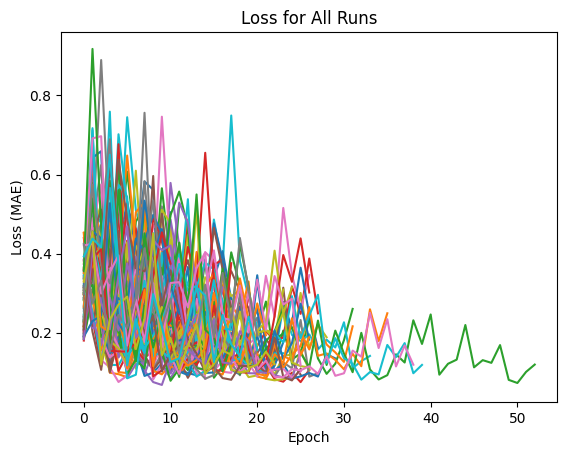

In [ ]:
# Plot the loss for each run
for i, history in enumerate(all_history):
    plt.plot(history['loss'], label=f'Loss (Run {i+1})')

plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.title('Loss for All Runs')
plt.show()


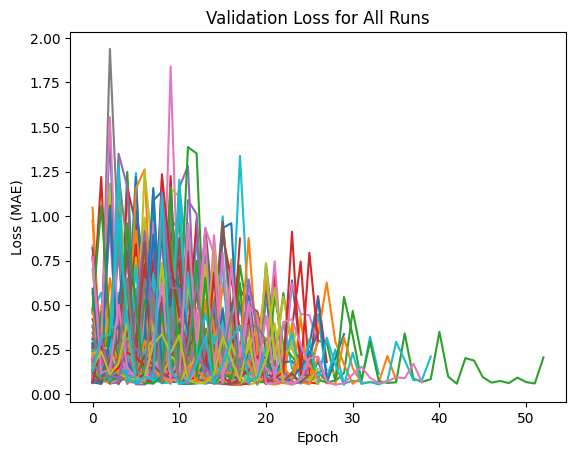

In [ ]:
# Plot the validation loss for each run
for i, history in enumerate(all_history):
    plt.plot(history['val_loss'], label=f'Validation Loss (Run {i+1})')

plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.title('Validation Loss for All Runs')
plt.show()

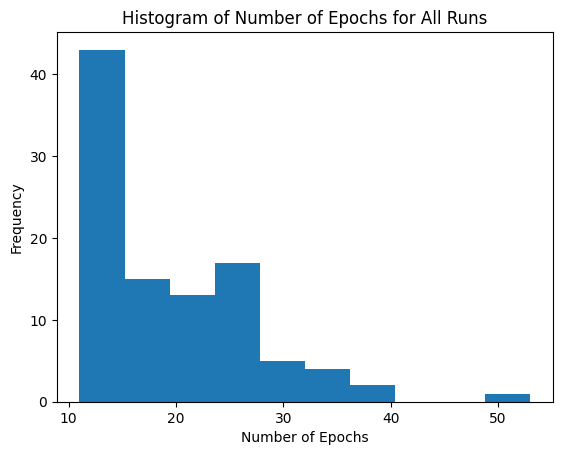

In [ ]:
# prompt: using the all_history list, create a histogram of the number of epochs

epochs_list = []
for history in all_history:
  epochs_list.append(len(history['loss']))

plt.hist(epochs_list, bins=10)  # Adjust bins as needed
plt.xlabel('Number of Epochs')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Epochs for All Runs')
plt.show()


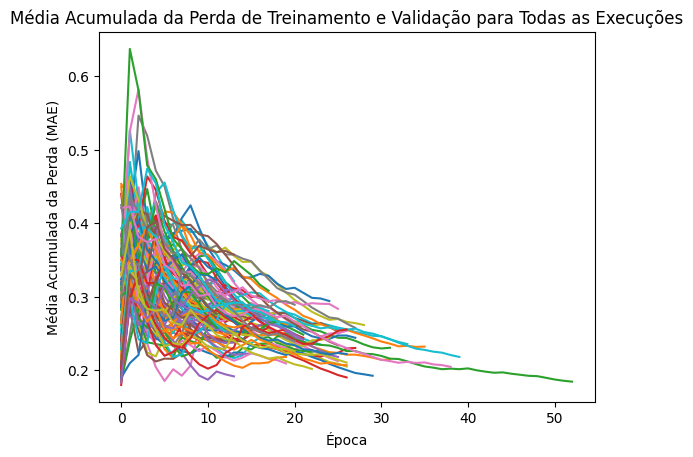

In [ ]:
# prompt: using the all_history list, create a graphic from acumullated mean

accumulated_loss = []

# Itere pelas histórias de cada execução
for history in all_history:
    loss = history['loss']

    # Calcule a média acumulada para cada época
    accumulated_loss.append([sum(loss[:i + 1]) / (i + 1) for i in range(len(loss))])

# Plote as médias acumuladas para todas as execuções
for i, loss in enumerate(accumulated_loss):
    plt.plot(loss, label=f'Média Acumulada da Perda de Validação (Execução {i + 1})')

plt.xlabel('Época')
plt.ylabel('Média Acumulada da Perda (MAE)')
plt.title('Média Acumulada da Perda de Treinamento e Validação para Todas as Execuções')
#plt.legend()
plt.show()

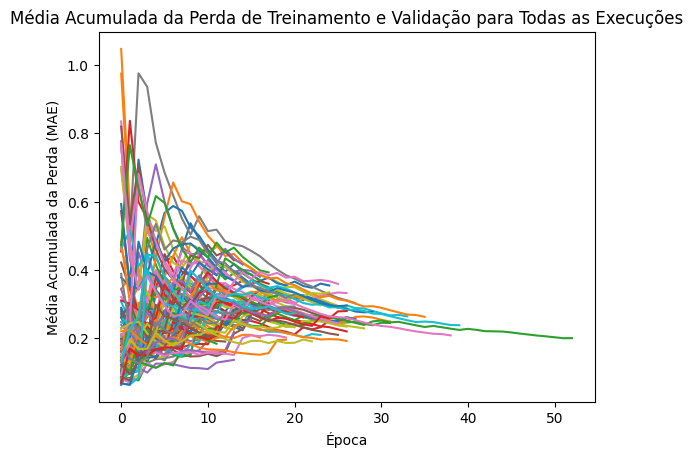

In [ ]:
# Inicialize listas para armazenar as médias acumuladas para loss e val_loss
accumulated_val_loss = []

# Itere pelas histórias de cada execução
for history in all_history:
    val_loss = history['val_loss']

    # Calcule a média acumulada para cada época
    accumulated_val_loss.append([sum(val_loss[:i + 1]) / (i + 1) for i in range(len(val_loss))])

# Plote as médias acumuladas para todas as execuções
for i, val_loss in enumerate(accumulated_val_loss):
    plt.plot(val_loss, label=f'Média Acumulada da Perda de Validação (Execução {i + 1})')

plt.xlabel('Época')
plt.ylabel('Média Acumulada da Perda (MAE)')
plt.title('Média Acumulada da Perda de Treinamento e Validação para Todas as Execuções')
#plt.legend()
plt.show()

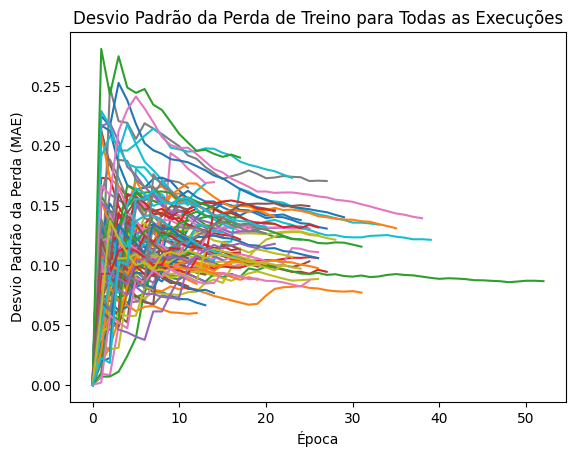

In [ ]:
# Inicialize listas para armazenar os desvios padrão para loss
std_loss = []

# Itere pelas histórias de cada execução
for history in all_history:
    loss = history['loss']

    # Calcule o desvio padrão para cada época
    std_loss.append([np.std(loss[:i + 1]) for i in range(len(loss))])

# Plote os desvios padrão para todas as execuções
for i, loss in enumerate(std_loss):
    plt.plot(loss, label=f'Desvio Padrão da Perda de Treino (Execução {i + 1})')

plt.xlabel('Época')
plt.ylabel('Desvio Padrão da Perda (MAE)')
plt.title('Desvio Padrão da Perda de Treino para Todas as Execuções')
plt.show()

In [ ]:
# Extrair a perda do histórico do melhor modelo
loss = best_history.history['val_loss']

# Plotar o gráfico da perda
plt.plot(loss)
plt.title('Evolução do validation loss')
plt.xlabel('Epoch')
plt.ylabel('val_Loss')

# Caminho para salvar o arquivo
file_path = f'/content/drive/MyDrive/Mestrado/Resultados/GRU/GRU_p{patience}_bestresults/GRU_1a{runs}runs_p{patience}_loss_plot_test.png'

# Criar os diretórios necessários
os.makedirs(os.path.dirname(file_path), exist_ok=True)

plt.savefig(file_path)

plt.show()

AttributeError: 'NoneType' object has no attribute 'history'

In [ ]:
# Converter as listas de métricas e desvios padrão em DataFrame do pandas
metrics_df = pd.DataFrame(all_metrics)

# Adicionar a coluna 'Run' ao DataFrame metrics_df
metrics_df['Run'] = range(0, runs)

# Caminho para salvar o arquivo CSV no Google Drive
file_path = f'/content/drive/MyDrive/Mestrado/Resultados/GRU/GRU_p{patience}_bestresults/GRU_1a{runs}runs_p{patience}_test.csv'

# Salvar o DataFrame metrics_df como um arquivo CSV
metrics_df.to_csv(file_path, index=False)

In [ ]:
df = pd.read_csv(f'/content/drive/MyDrive/Mestrado/Resultados/GRU/GRU_p{patience}_bestresults/GRU_1a{runs}runs_p{patience}_test.csv')

# Encontra a linha com o menor valor na coluna MAPE
min_mape_row = df.loc[df['MAPE'].idxmin()]

# Exibe o resultado
print(min_mape_row)

MAE     1.126397e+03
MSE     1.970603e+06
RMSE    1.403782e+03
MAPE    1.009100e+00
R2      9.662175e-01
Run     4.800000e+01
Name: 48, dtype: float64


In [ ]:
# Função para carregar o melhor modelo e suas métricas
def load_model_and_metrics(filename):
    # Carregar o modelo e suas métricas
    model = tf.keras.models.load_model(filename + '.keras')
    metrics = {}
    with open(filename + '.txt', 'r') as f:
        for line in f:
            key, value = line.strip().split(': ')
            if key == 'Seed':
                metrics[key] = int(value)
            else:
                metrics[key] = float(value)

    # Carregar o otimizador
    with open(filename + '_optimizer.pkl', 'rb') as f:
        optimizer_config = pickle.load(f)
    optimizer = tf.keras.optimizers.get({'class_name': optimizer_config['name'], 'config': optimizer_config})

    return model, optimizer, metrics

# Caminho do melhor modelo salvo
results_dir = f'/content/drive/MyDrive/Mestrado/Resultados/GRU/GRU_p{patience}_bestresults'
best_model_path = os.path.join(results_dir, 'best_model')

# Carregar o melhor modelo e suas métricas
best_model, best_optimizer, best_metrics = load_model_and_metrics(best_model_path)

# Fazer previsões usando o melhor modelo
val_predict = best_model.predict(validation_dataset)
predict = (val_predict * train_std) + train_mean

# Ajustar os dados de entrada e previstos para terem o mesmo tamanho
y_real = test_not_norm[lookback:]
y_predict = predict.squeeze()

# Organizar datas

# Plotar os dados reais e as previsões
plt.figure(figsize=(10, 6))
plt.plot(y_real, label='Real')
plt.plot(y_predict, label='Previsão')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.title('Comparação entre os valores reais e as previsões')
plt.legend()

# Ajustar o eixo x para exibir as datas corretamente# Ajustar o eixo x para exibir as datas corretamente
plt.xticks(np.arange(1, len(df_test['Date']), step=50), df_test['Date'][np.arange(df_test.index[0], df_test.index[-1], step=50)], ha='right')


# Caminho para salvar o arquivo
file_path = f'/content/drive/MyDrive/Mestrado/Resultados/GRU/GRU_p{patience}_bestresults/GRU_1a{runs}runs_p{patience}_comparison_plot_test.png'

# Criar os diretórios necessários
os.makedirs(os.path.dirname(file_path), exist_ok=True)

# Salvar o gráfico
plt.savefig(file_path)

# Mostrar o gráfico
plt.show()

ValueError: File not found: filepath=/content/drive/MyDrive/Mestrado/Resultados/GRU/GRU_p10_bestresults/best_model.keras. Please ensure the file is an accessible `.keras` zip file.

#Carregar o melhor modelo para ver se o resultado é o mesmo

In [ ]:
def load_model_and_metrics(filename):
    # Carregar o modelo e suas métricas
    model = tf.keras.models.load_model(filename + '.keras')
    metrics = {}
    with open(filename + '.txt', 'r') as f:
        for line in f:
            key, value = line.strip().split(': ')
            if key == 'Seed':
                metrics[key] = int(value)
            else:
                metrics[key] = float(value)

    # Carregar o otimizador
    with open(filename + '_optimizer.pkl', 'rb') as f:
        optimizer_config = pickle.load(f)
    optimizer = tf.keras.optimizers.get({'class_name': optimizer_config['name'], 'config': optimizer_config})

    return model, optimizer, metrics


In [ ]:
# Carrega o melhor modelo e suas métricas
best_model, best_optimizer, best_metrics = load_model_and_metrics(os.path.join(results_dir, 'best_model'))
print("Melhor MAPE:", best_metrics['MAPE'])

# Definir a seed para reproduzir os resultados
seed = best_metrics['Seed']
random.seed(seed)
tf.random.set_seed(seed)


Melhor MAPE: 0.9560857124902419


In [ ]:

# Constrói o modelo GRU com os melhores parâmetros
def build_model(n_layers, n_units_GRU1, dropout_rate_GRU1, activation_GRU1, n_units_dense, activation_dense, lookback):
    model = Sequential()
    model.add(GRU(n_units_GRU1, activation=activation_GRU1, input_shape=(lookback, 1)))
    model.add(Dropout(dropout_rate_GRU1))
    model.add(Dense(n_units_dense, activation=activation_dense))
    model.add(Dense(1))
    return model

# Construir e compilar o modelo
model = build_model(n_layers, n_units_GRU1, dropout_rate_GRU1, activation_GRU1, n_units_dense, activation_dense, lookback)
model.compile(optimizer=best_optimizer, loss='mae')

# Definir os callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

# Treinar o modelo
history = model.fit(train_dataset, epochs=200, validation_data=validation_dataset, callbacks=[early_stopping], verbose=1)

# Fazer previsões
val_predict = model.predict(validation_dataset)
predict = (val_predict * train_std) + train_mean

# Ajustar os dados de entrada e previstos para terem o mesmo tamanho
y_real = test_not_norm[lookback:]
y_predict = predict.squeeze()

# Calcular métricas
mae = mean_absolute_error(y_real, y_predict)
mse = mean_squared_error(y_real, y_predict)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_real - y_predict) / y_real)) * 100
r2 = r2_score(y_real, y_predict)

# Imprimir as métricas
print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}, MAPE: {mape}, R2: {r2}")


Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.3585 - val_loss: 0.3406
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.6462 - val_loss: 0.0893
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0613 - val_loss: 0.1157
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0666 - val_loss: 0.0703
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.1914 - val_loss: 0.0651
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.1535 - val_loss: 0.1187
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.1301 - val_loss: 0.0577
Epoch 8/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.1971 - val_loss: 0.3287
Epoch 9/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.4324 - val_loss: 0.0604
Epoch 10/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.2184 - val_loss: 0.2300
Epoch 11/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.1026 - val_loss: 0.0666
Epoch 12/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.1

# Fim